# Graph-Parametrized Equivariant 1-form Representation Learning

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [2]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import networkx as nx
import torch_geometric

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx, from_networkx
import plotly.graph_objects as go
import plotly.express as px

# Generate some graph data for examples

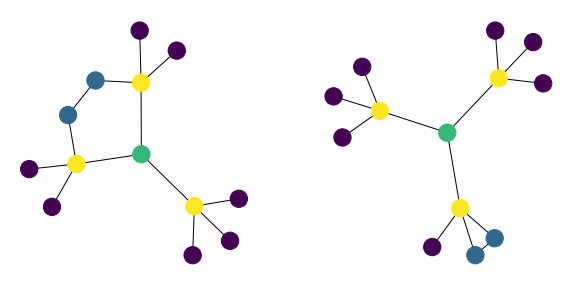

In [3]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)

# draw a tree graph with 10 nodes
H = nx.balanced_tree(3, 2)

# add an edge between 7 and 8
H.add_edge(7, 8)

# calculate the spring layout for H
Gpos = nx.spring_layout(G)
Hpos = nx.spring_layout(H)

# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))
plt.subplot(1, 2, 2)
nx.draw(H, pos=Hpos, with_labels=False, font_weight='bold', node_color=list(dict(H.degree()).values()))

## Turning graphs into tensors

In [4]:
# a function for turning a path into a chain
def nxgraph_to_chain(graph, features):
    """ 
    A function for turning a graph into a chain
    Inputs: 
        graph: an nx_graph
        features: a torch tensor of features for each node of size (m,n) where m is the number of nodes and n is the feature dimension

    outputs:
        ch: a torch tensor of shape (r,2,n) where r is the number of edges and n is the feature dimension
    """

    # get node features
    node_features = features

    # get edges
    edge_index = torch.tensor(list(graph.edges))

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [5]:
Gpos = torch.tensor(list(Gpos.values()))
Hpos = torch.tensor(list(Hpos.values()))

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/983239627.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  Gpos = torch.tensor(list(Gpos.values()))


We are going to go through the general procedure of turning a graph into a tensor by example before generalizing to a function.

In [6]:
# extract the degree sequence from the graph
degree_sequence = list(dict(G.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

one_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0]])

In [7]:
# extract the degree sequence from the graph
degree_sequence = list(dict(H.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
Hone_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

Hone_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

By convention, we will always use $Z$ to denote matrix the positional, equivariant node features, and $H$ to denote the matrix of 'scalar' or non-equivariant node features. If the position of the nodes is in $\mathbb{R}^n$ and the scalar features are in $\mathbb{R}^m$, the respective matrices are in $\mathbb{R}^{s_0 \times n}$ and $\mathbb{R}^{s_0 \times m}$, where $s_0$ is the number of nodes in the graph.

In [8]:
# make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
Gdata = {'graph': G, 'Z': Gpos.float(), 'H': one_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(G, Gpos), 'H_chains' : nxgraph_to_chain(G, one_hot_degree_sequence).float()}

# make a dictionary containing: the graph H, the node positions Hpos, and the one hot degree sequence, the chains
Hdata = {'graph': H, 'Z': Hpos.float(), 'H': Hone_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(H, Hpos), 'H_chains' : nxgraph_to_chain(H, Hone_hot_degree_sequence).float()}

We will also use the coboundary of the positional and scalar features. These matrices are $dZ \in \mathbb{R}^{s_1 \times n}$ and $dH \in \mathbb{R}^{s_1 \times m}$, where $s_1$ is the number of edges in the graph. These encode the tangent vector along each edge wrt these respective coordinate types.

In [9]:
Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])
Hdata['dZ'] = (Hdata['Z_chains'][:,1,:] - Hdata['Z_chains'][:,0,:])
Hdata['dH'] = (Hdata['H_chains'][:,1,:] - Hdata['H_chains'][:,0,:])

base = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']), axis=1)

In [10]:
dimH = 5
dimZ = 2

num_vf = 3

# generate a torch sequential neural network with two hidden layers
model = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [11]:
# create a forward pass
def fwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, 2*h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # apply the model to the invariant summary
    out = model(X @ base)

    # calculate dim h
    dimh = base.shape[1] // 2

    # calculate num_vf
    nvf = int(out.shape[1] / (1+2*dimh))


    # stack the bases along the batch dimension
    bases = torch.stack([base] * X.shape[0])

    # 
    Y = X.unsqueeze(-1)

    full_bases = torch.cat((Y,bases),axis=-1)

    out = out.view(-1, nvf, 1+2*dimh)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [12]:
def simple_vf_plot(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

In [13]:
# times the base on the right by a 2d rotation matrix of angle 
def rot(base, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R.float() @ base 

def rot2(pos, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return pos.float() @ R.T.float()


We check that the rotations of the base indeed induce a corresponding rotation of the vector field.

Text(0.5, 0.98, 'Vector field for different rotations of the base')

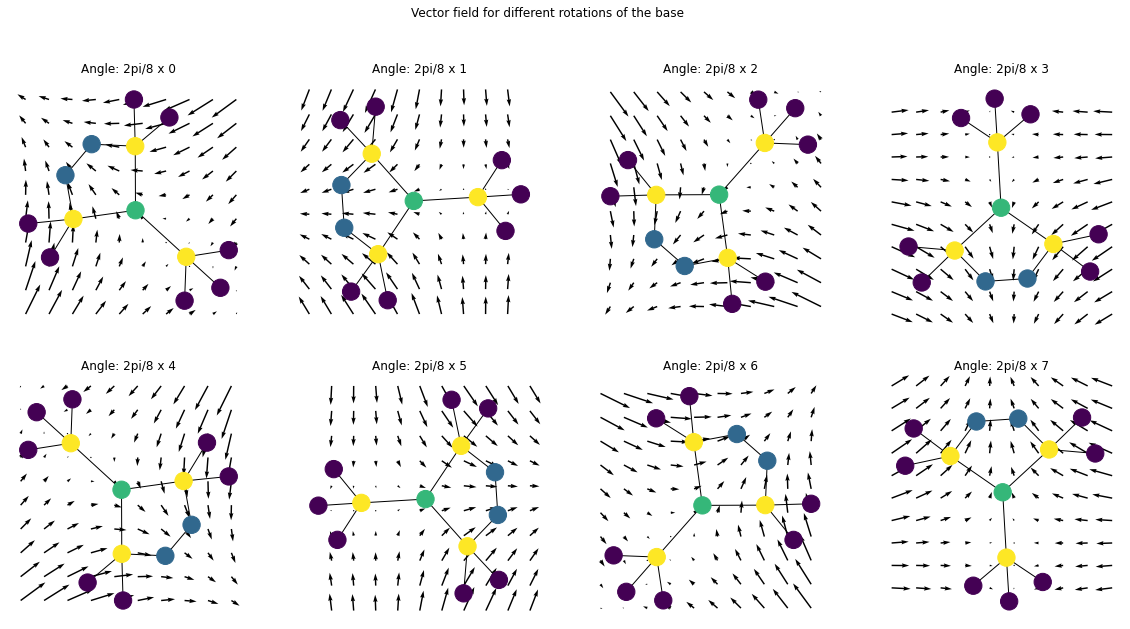

In [14]:
angles = np.arange(0,2*np.pi,2*np.pi/8)

comp = 2

fig, ax = plt.subplots(2,4,figsize=(20,10))

for i in range(8):
    simple_vf_plot(model, rot(base,angles[i]), ax[i//4,i%4], comp=comp)
    plt.subplot(2, 4, i+1)
    nx.draw(G, pos=rot2(Gpos,angles[i]), with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Angle: ' + str("2pi/8 x ") + str(i) )


# give the plot a title
plt.suptitle('Vector field for different rotations of the base')

An interesting remark is that the symmetries of the graph embedding are preserved as symmetries of the vector field. See the report for a basic mathematical proof of this fact.

## General Data Tensorization

In [15]:
# a function for turning graph features into tensors
def tensorize(G, Z, H):
    """ 
    A function for extracting graph embedding data:
    Inputs: 
        G: an nx_graph
        Z: a torch tensor of equivariant features of size (m_0,n) 
                where m_0 is the number of nodes and n is the equivariant feature dimension
        H: a torch tensor of non-equivariant features of size (m_0,l) 
                where m_0 is the number of nodes and l is the feature dimension
        
    Outputs:
        Gdata: a dictionary containing the graph, the node positions, the one hot degree sequence, the chains, and the B matrix
    """

    # make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
    Gdata = {'graph': G, 'Z': Z.float(), 'H': H.float(), 'Z_chains': nxgraph_to_chain(G, Z).float(), 'H_chains' : nxgraph_to_chain(G, H).float()}

    Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
    Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])

    Gdata['B'] = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']), axis=1)

    return Gdata

In [16]:
# test 
Gdata = tensorize(G,Z=Gpos,H=one_hot_degree_sequence)

## Integration

Now we prepare the code for integration of the edges in the graph against the vector field. We will use the trapezoidal rule for this.

In [17]:
# a function for turning a path into a chain
def graph_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = torch.tensor(graph['x'])

    # get edges
    edge_index =torch.tensor(data['edge_index']).T

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain


In [18]:
# create a forward pass
def Vfwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # original shape of X
    orig_shape = X.shape

    # apply the model to the invariant summary
    out = model(X @ base)

    # calculate dim h
    dimh = base.shape[1] // 2

    # calculate num_vf
    nvf = int(out.shape[-1] / (1+2*dimh))    

    # add a dimension to X
    Y = X.unsqueeze(-1)

    # combine dimensions 1 and 2 of Y so that batch/edge and discrete steps are combined
    Y = Y.reshape(Y.shape[0]*Y.shape[1],Y.shape[2], Y.shape[3])


    bases = torch.stack([base] * Y.shape[0])

    # concat the bases along the batch dimension
    # these are the base vectors which generate the vector field
    full_bases = torch.cat((Y,bases),axis=-1)

    # reshape the output of the model
    out = out.view(-1, nvf, 1+2*dimh)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [19]:
# a function for turning a chain into an integratrix
def equi_integratrix(vf,chain, B, d = 5):
    """
    A function for generating an integratrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    B : a torch tensor of shape (z,h)
        The invariant summary matrix of the chain

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features)

    # apply the vector field to the discretized chain
    out = Vfwd(chain, vf, B).reshape((r,d,n,-1))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

### $O(n)$ Invariance of Integratrices

In theory, rotated/reflected copies of an embedded graph should produce the same integratix against our equivariant vector field. An important aspect is that the vector field does require the specific rotation of the graph to be known. Thus, if two graphs are related by an unknown rotation they will automatically produce the same integratrix without having to align them in any way. In summary, $O(n)$-equivariant vector fields produce $O(n)$-invariant integratrices, and do not require any alignment. We confirm this numerically below. 

In [20]:
# make a rotated version of G
Gdata_rot = tensorize(G,Z=rot2(Gpos,np.pi/2),H=one_hot_degree_sequence)

# calculate integratrices, note pi/2 is not an input
A = equi_integratrix(model, Gdata['Z_chains'], Gdata['B'])
B = equi_integratrix(model, Gdata_rot['Z_chains'], Gdata_rot['B'])

# compare the integratrices up to a small numerical error
A-B < 1e-8

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

Looks good!

# Synthetic Example
## 2d Synthetic Graph Isomorphism Testing

In this synthetic example, we will embed two different isomorphic classes of graphs using the spring layout. Recomputing the spring layout for each graph will produce different embeddings which will be close to isometric with minor variations. 

In [21]:
# generate 10 different non-isomorphic graphs with the same nodes, edges and degree sequence
graphs = [nx.random_degree_sequence_graph([3,3,3,3,3,2,2,1,1,1], tries=100) for i in range(3)]

/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  else mpath.Path(np.asarray(seg, float))
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


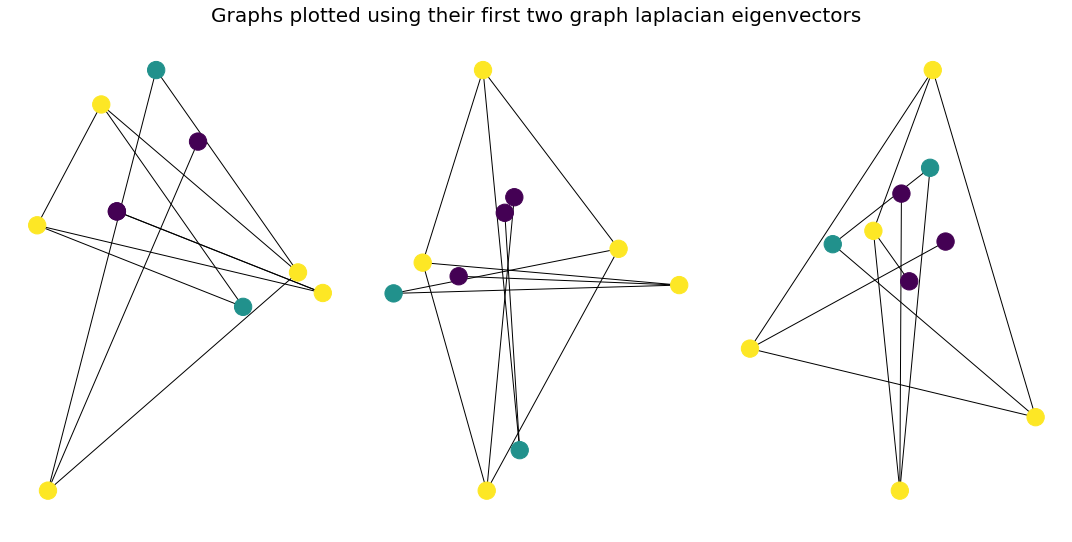

In [22]:
# calculate the first two graph laplacian eigenvectors
eigvecs = [torch.linalg.eig(torch.tensor(nx.laplacian_matrix(graph).todense()).float())[1][:,1:3] for graph in graphs]

# plot the graphs using their first two graph laplacian eigenvectors
plt.figure(figsize=(15,15))

for i in range(3):
    plt.subplot(2, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

# add title
plt.suptitle('Graphs plotted using their first two graph laplacian eigenvectors', fontsize=20)

# center the title
plt.tight_layout()

Almost looks like a Kandinsky painting!

### Learning Characteristic Vector Fields

The goal of this experiment is purely pedagogical. We wish to give the learning algorithm the objective of learning a vector field which is characteristic of the graph class. The idea is that each vector field should produce a large integratrix for its own graph and a small integratrix for the other graph.

In [23]:
# data transformation 

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(torch.tensor([3,3,3,3,3,2,2,1,1,1])).float()

# tensorize the graphs with the laplacian eigenvectors as the equivariant features
# and the one hot degree sequence as the non-equivariant features
data = [tensorize(graphs[i], Z=eigvecs[i], H=one_hot_degree_sequence) for i in range(3)]

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/3333705.py:17: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:276.)
  Gdata = {'graph': G, 'Z': Z.float(), 'H': H.float(), 'Z_chains': nxgraph_to_chain(G, Z).float(), 'H_chains' : nxgraph_to_chain(G, H).float()}


In [24]:
dimH = 4
dimZ = 2
num_vf = 3

# generate a torch sequential neural network with two hidden layers
isomodel = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [25]:
def simple_vf_plot2(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,20)
    y = np.linspace(-radius,radius,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

First we plot one of the initial graph-parametrized vector fields.

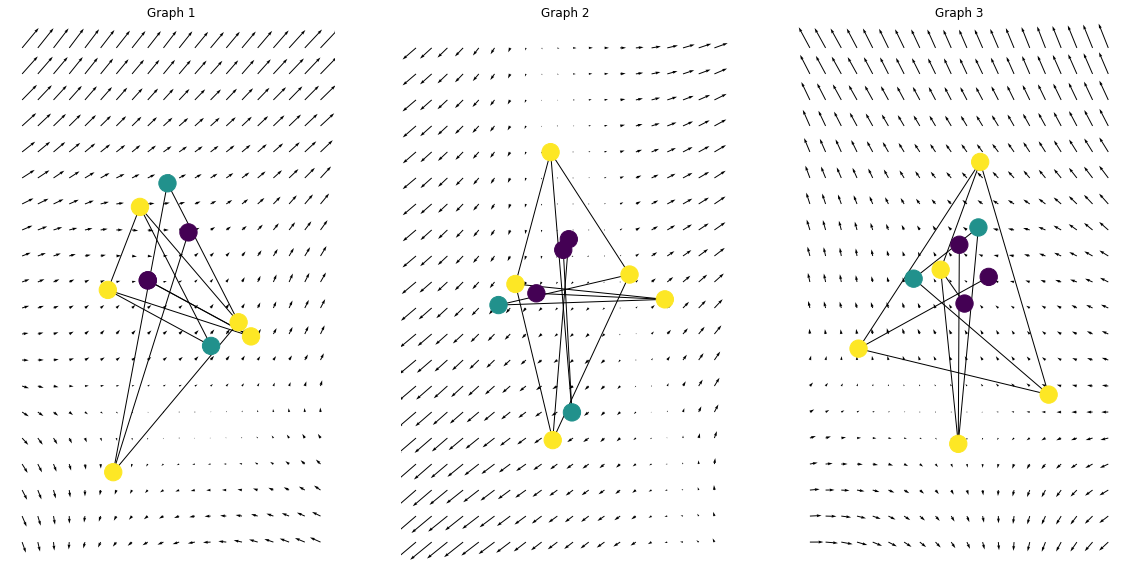

In [26]:
# plot the graphs and initialized vector fields
fig, ax = plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    simple_vf_plot2(isomodel, data[i]['B'], ax[i%5], comp=0)
    plt.subplot(1, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Graph ' + str(i+1) )





In [27]:
labels = torch.tensor([0,1,2])

# intialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(isomodel.parameters(), lr=0.001)

In [28]:
# train the model
for epoch in range(20):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

    for i in range(3):

        X = outputs[i]

        #X = torch.sum(X, axis = 0)
        X = torch.diag(X.T @ X)

        # perform softmax on X
        X = torch.nn.functional.softmax(X)

        outputs[i] = X

    loss = sum([criterion(outputs[i], labels[i]) for i in range(3)])
    loss.backward()
    optimizer.step()

    
    # print statistics every 5 epochs
    if epoch % 5 == 0:    
        print('Epoch: ', epoch, 'Loss: ', loss.item())


Epoch:  0 Loss:  3.2959556579589844
Epoch:  5 Loss:  3.2223892211914062
Epoch:  10 Loss:  2.7016372680664062
Epoch:  15 Loss:  1.8431096076965332


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/1215688682.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


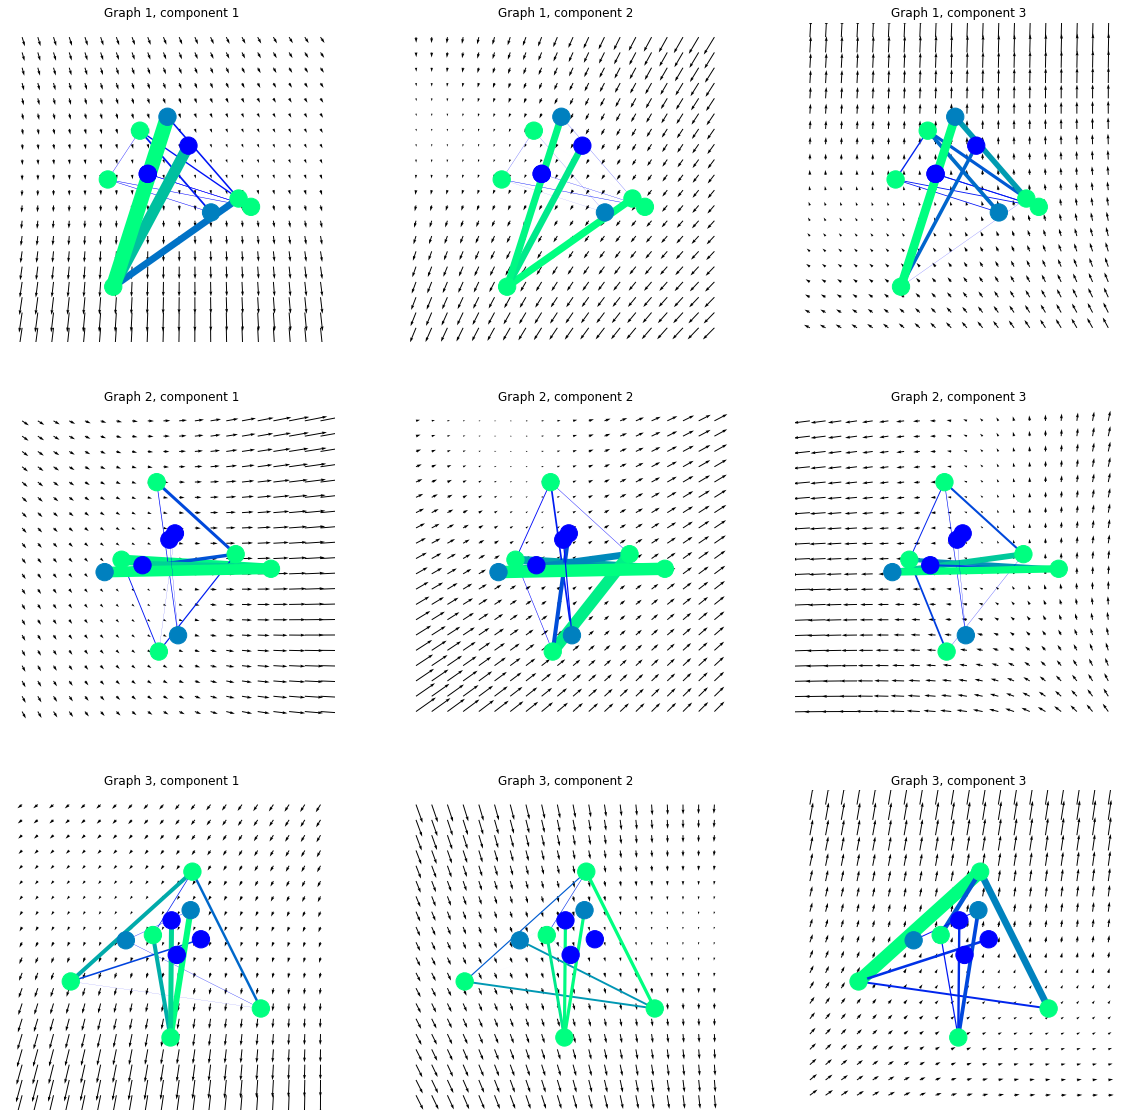

In [29]:
# make the same plot in a 3x3 iterating over the components of the vector field
fig, ax = plt.subplots(3,3,figsize=(20,20))

outputs = [(equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']))**2 for i in range(3)]

for i in range(3):
    for j in range(3):
        simple_vf_plot2(isomodel, data[i]['B'], ax[i,j], comp=j)
        plt.subplot(3, 3, 3*i+j+1)
        nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', cmap = plt.cm.winter, node_color=list(dict(graphs[i].degree()).values()), edge_cmap = plt.cm.winter, edge_color = 5*outputs[i][:,j].detach().numpy(), width=2*outputs[i][:,j].detach().numpy())



        # title the subplot with the angle in radians
        plt.title('Graph ' + str(i+1) + ', component ' + str(j+1) )

# swap the subplots of the figure by a transposition
ax = ax.T

Just for completeness, we will check the the model actually learns to the classify the three graphs correctly.

In [35]:
# calculate test accuracy
outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

for i in range(3):
    
        X = outputs[i]
    
        X = torch.diag(X.T @ X)
    
        # perform softmax on X
        X = torch.nn.functional.softmax(X)
    
        outputs[i] = X


# calculate test accuracy
correct = 0
total = 0

for i in range(3):
    total += 1
    if torch.argmax(outputs[i]) == labels[i]:
        correct += 1

print('Test Accuracy: ', correct/total)


Test Accuracy:  1.0


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/4285167842.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


In [36]:
outputs = torch.stack(outputs)

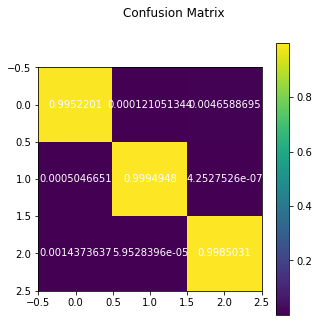

In [37]:
# plot outputs as a heatmap
plt.figure(figsize=(5,5))
plt.imshow(outputs.detach().numpy(), cmap='viridis' , interpolation='nearest')
plt.colorbar()

# add an argument to imshow to display the values of outputs
for i in range(3):
    for j in range(3):
        plt.text(j, i, outputs[i,j].detach().numpy(), ha="center", va="center", color="w")


# add a title confusion matrix
plt.suptitle("Confusion Matrix")

plt.show()


# Graph Classification Tasks

Now we move onto the benchmarking phase. 

### Data pre-processing and plotting functions

In [41]:
# load data,
# note that 'node attributes' are the positional features
dataset = TUDataset(root='/tmp/COX2', name='COX2', use_node_attr=True)

In [42]:
# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/1874507054.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(g['x'][:,:3])
/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/1874507054.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(g['x'][:,3:])


In [43]:


def plot_molecule(tensorized):
    """ 
    A function for plotting a molecule

    Parameters
    ----------
    tensorized : a dictionary containing the graph, the node positions, the one hot degree sequence, the chains, and the B matrix
    
    Returns
    -------
    fig : a plotly figure
        A plotly figure containing the plot of the molecule
    """

    # invert one hot encoding of tensorized['H']
    H = torch.argmax(tensorized['H'],axis=1)

    fig = go.Figure(data=[go.Scatter3d(x=tensorized['Z'][:,0], y=tensorized['Z'][:,1], z=tensorized['Z'][:,2],
                                      mode='markers', marker=dict(size=7, color=H, colorscale='Viridis', opacity=0.8),showlegend=False)])

    for i in range(tensorized['Z_chains'].shape[0]):
        fig.add_trace(go.Scatter3d(x=[tensorized['Z_chains'][i,0,0], tensorized['Z_chains'][i,1,0]],
                                   y=[tensorized['Z_chains'][i,0,1], tensorized['Z_chains'][i,1,1]],
                                   z=[tensorized['Z_chains'][i,0,2], tensorized['Z_chains'][i,1,2]],
                                   mode='lines',
                                   showlegend=False,))
        
    # make it square and zoom to fit
    fig.update_layout(width=600, height=500, autosize=False, margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(scene_aspectmode='cube')

    
    
    return fig

# plot the molecule
fig = plot_molecule(tdata[3])

fig.show()


# Graph Parametrized Equivariant Vector Field (EVf) model training functions

Below, we define a version of the Equivariant Vector Field model which is parametrized by a graph, following the simple algorithm described in the report. We also define the training loop for this model.

In [44]:
class EVfModel(torch.nn.Module):
    def __init__(
        self,
        dimH,
        num_classes = 2,
        num_vf = 5,
        evf_hidden_dim= 32,
        classifier_hidden_dim=16
    ):
    
        super().__init__()

        self.evf = nn.Sequential(nn.Linear(2*dimH, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, (1+2*dimH)*num_vf)
                      )

        self.classifier = nn.Sequential(nn.Linear(num_vf, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, num_classes)
                      )
        
    def forward(self, tnsrdata):

        # calculate the invariant summary integratrix
        X = equi_integratrix(self.evf, tnsrdata['Z_chains'], tnsrdata['B'])

        # L2 readout layer
        X = torch.diag(X.T @ X)

        # apply the classifier to the output of the vector field
        pred = self.classifier(X)

        # apply softmax to the output of the classifier
        pred = nn.functional.log_softmax(pred, -1)

        return pred


In [45]:
from numpy import random

# generalise the above into a single train function
def train_model(model, criterion, optimizer, tdata, epochs=40, batch_size=5):

    # train/test split for tdata
    train_tdata = tdata[:int(len(tdata)*0.8)]
    test_tdata = tdata[int(len(tdata)*0.8):]

    # store training loss and accuracy
    all_loses = []
    all_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        # store epoch loss
        epoch_loss = 0

        # print training accuracy
        correct = 0
        total = 0

        # shuffle the training data
        random.shuffle(train_tdata)

        # iterate through the training data batch by batch

        for i in range(0, len(train_tdata), batch_size):

            # create a batch of training data
            batch = train_tdata[i:i+batch_size]


            for j in range(len(batch)):
                pred = model(batch[j])


                if torch.argmax(pred) == batch[j]['y']:
                    correct += 1

                total += 1

                loss = criterion(pred, batch[j]['y'])

                loss.backward() 

                optimizer.step()

                epoch_loss += loss.item()

                # zero the parameter gradients
                optimizer.zero_grad()

        #print total loss over the epoch
        print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
        print('Training Accuracy: ', correct/total, "\n")

        all_loses.append(epoch_loss/len(tdata))
        all_accuracies.append(correct/total)


    print('Finished Training')

    # initialise 2 subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plot loss
    ax1.plot(all_loses)
    # add title
    ax1.set_title('Training Loss')

    # plot accuracy
    ax2.plot(all_accuracies)
    # add title
    ax2.set_title('Training Accuracy')

    # print test accuracy
    correct = 0

    for i in range(len(test_tdata)):
        pred = model(test_tdata[i])

        if torch.argmax(pred) == test_tdata[i]['y']:
            correct += 1

    print('Test Accuracy: ', correct/len(test_tdata))

    return model, all_loses, all_accuracies, correct/len(test_tdata)

# Baseline Model Functions

In [46]:
# import baseline models using pytorch geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv

# construct a GCN model
class GCN(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16, num_layers = 4):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.convstart = GCNConv(dimH, self.hidden_dim)
        for i in range(self.num_layers-2):
            self.add_module('conv{}'.format(i+2), GCNConv(self.hidden_dim, self.hidden_dim))
        self.convend = GCNConv(self.hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.convstart(x, edge_index).relu()
        for i in range(self.num_layers-2):
            x = self._modules['conv{}'.format(i+2)](x, edge_index).relu()
        x = self.convend(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)
    

        return x
    
# construct a GAT model 
class GAT(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16, num_layers = 4):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.convstart = GATConv(dimH, self.hidden_dim, heads=8, dropout=0.6)
        for i in range(num_layers-2):
            self.add_module('conv{}'.format(i+2), GATConv(self.hidden_dim * 8, self.hidden_dim, heads=8, dropout=0.6))

        self.convend = GATConv(16 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.convstart(x, edge_index).relu()
        for i in range(self.num_layers-2):
            x = self._modules['conv{}'.format(i+2)](x, edge_index).relu()
        x = self.convend(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)

        return x
    
# construct a SAGE model
class SAGE(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16):
        super().__init__()

        self.conv1 = SAGEConv(dimH, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)

        return x
    
# construct a GIN model
class GIN(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16):
        super().__init__()

        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(dimH, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        ))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        x = torch.sum(x,axis=0)

        x = nn.functional.log_softmax(x, -1)

        return x
    



In [47]:
# generalise the above into a single train function
def baseline_train_model(model, criterion, optimizer, dataset, epochs=40, batch_size=5):

    # create a random permutation of len(dataset)
    random_perm = np.random.permutation(len(dataset))

    # permute the dataset
    dataset = dataset[random_perm]

    # train/test split for tdata
    train_tdata = dataset[:int(len(tdata)*0.8)]
    test_tdata = dataset[int(len(tdata)*0.8):]

    # store training loss and accuracy
    all_loses = []
    all_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        # store epoch loss
        epoch_loss = 0

        # print training accuracy
        correct = 0
        total = 0

        # shuffle the training data
         # create a random permutation of len(dataset)
        random_perm = np.random.permutation(len(train_tdata))
        train_tdata = train_tdata[random_perm]


        # iterate through the training data batch by batch

        for i in range(0, len(train_tdata), batch_size):

            # create a batch of training data
            batch = train_tdata[i:i+batch_size]


            for j in range(len(batch)):

                pred = model(batch[j])




                if torch.argmax(pred) == batch[j].y[0]:
                    correct += 1

                total += 1

                loss = criterion(pred, batch[j].y[0])

                loss.backward() 

                optimizer.step()

                epoch_loss += loss.item()

                # zero the parameter gradients
                optimizer.zero_grad()

        #print total loss over the epoch
        print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
        print('Training Accuracy: ', correct/total, "\n")

        all_loses.append(epoch_loss/len(tdata))
        all_accuracies.append(correct/total)


    print('Finished Training')

    # initialise 2 subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plot loss
    ax1.plot(all_loses)
    # add title
    ax1.set_title('Training Loss')

    # plot accuracy
    ax2.plot(all_accuracies)
    # add title
    ax2.set_title('Training Accuracy')

    # print test accuracy
    correct = 0

    for i in range(len(test_tdata)):
        pred = model(test_tdata[i])

        if torch.argmax(pred) == test_tdata[i]['y']:
            correct += 1

    print('Test Accuracy: ', correct/len(test_tdata))

    return model, all_loses, all_accuracies, correct/len(test_tdata)

def full_baseline_model(model, dataset, epochs = 20):

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    model, loses, accuracies, test_accuracy = baseline_train_model(model, criterion, optimizer, dataset, epochs=epochs, batch_size=5)

    print("Test Accuracy: ", test_accuracy)

    return loses, accuracies, test_accuracy


# DHFR

### DHFR Model Testing

In [ ]:
dataset = TUDataset(root='/tmp/DHFR', name='DHFR', use_node_attr=True)

# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

# plot the molecule
fig = plot_molecule(tdata[0])

fig.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/937239055.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/937239055.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Number of Parameters:  50 k
Epoch:  0 Loss:  3.692737179939824
Training Accuracy:  0.5794701986754967 

Epoch:  1 Loss:  1.0262386194830815
Training Accuracy:  0.6639072847682119 

Epoch:  2 Loss:  1.0519523917829658
Training Accuracy:  0.6324503311258278 

Epoch:  3 Loss:  0.9647968023325932
Training Accuracy:  0.6241721854304636 

Epoch:  4 Loss:  0.5758127354162184
Training Accuracy:  0.6622516556291391 

Epoch:  5 Loss:  0.6659753513726853
Training Accuracy:  0.6903973509933775 

Epoch:  6 Loss:  0.549194060940561
Training Accuracy:  0.6771523178807947 

Epoch:  7 Loss:  0.7049159998285282
Training Accuracy:  0.6605960264900662 

Epoch:  8 Loss:  1.22162349209277
Training Accuracy:  0.6672185430463576 

Epoch:  9 Loss:  0.7057612153692037
Training Accuracy:  0.6788079470198676 

Epoch:  10 Loss:  0.5449434881121236
Training Accuracy:  0.6837748344370861 

Epoch:  11 Loss:  0.589200775569244
Training Accuracy:  0.7086092715231788 

Epoch:  12 Loss:  0.6756390327319962
Training Accur

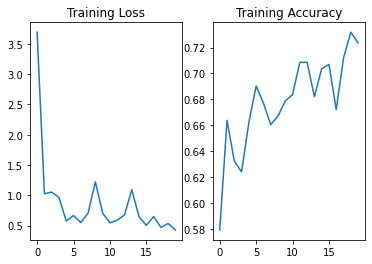

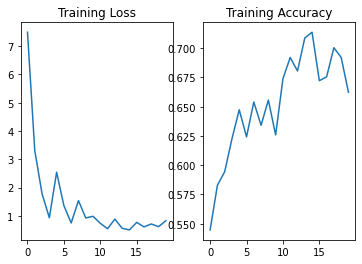

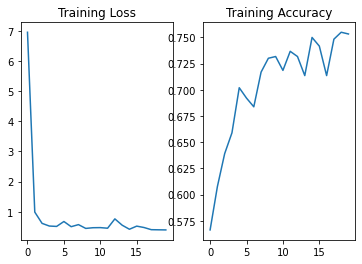

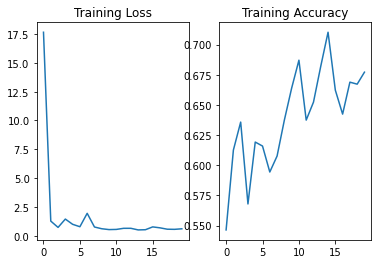

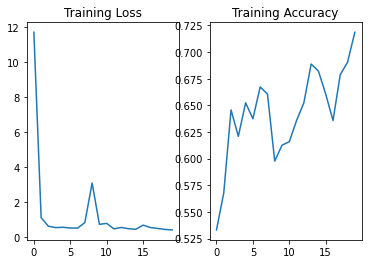

In [ ]:
EVF_accuracies = []
EVF_losses = []
EVF_train_accuracies = []

for i in range(5):
    # construct evf mode
    model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 64, classifier_hidden_dim=16)

    # initialise cross-entropy loss and adam optimizer
    criterion = nn.CrossEntropyLoss()

    # build an optimizer on evf and classifer parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # plot number of parameters in model
    print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

    # train the model
    model, all_loses, all_accuracies, test_accuracy = train_model(model, criterion, optimizer, tdata, epochs=20, batch_size=5)

    EVF_accuracies.append(test_accuracy)
    EVF_losses.append(all_loses)
    EVF_train_accuracies.append(all_accuracies)

print("Average Test Accuracy: ", sum(accuracies)/len(accuracies))
print("Standard Deviation: ", np.std(accuracies))


# take the mean of the losses
EVF_losses = torch.mean(torch.tensor(EVF_losses), axis=0)

# take the mean of the training accuracies
EVF_train_accuracies = torch.mean(torch.tensor(EVF_train_accuracies), axis=0)


### DHFR Baseline Testing

In [ ]:
# make a new TU dataset with position features
dataset = TUDataset(root='/tmp/DHFR', name='DHFR', use_node_attr=False)

Number of Parameters:  56 k
Epoch:  0 Loss:  0.5697607301155884
Training Accuracy:  0.5596026490066225 

Epoch:  1 Loss:  0.5474420179608007
Training Accuracy:  0.5778145695364238 

Epoch:  2 Loss:  0.5444584489065819
Training Accuracy:  0.5695364238410596 

Epoch:  3 Loss:  0.5404199440347612
Training Accuracy:  0.5827814569536424 

Epoch:  4 Loss:  0.5332263707129098
Training Accuracy:  0.6059602649006622 

Epoch:  5 Loss:  0.5315652517552572
Training Accuracy:  0.5910596026490066 

Epoch:  6 Loss:  0.5306856801151913
Training Accuracy:  0.6175496688741722 

Epoch:  7 Loss:  0.5149897956954581
Training Accuracy:  0.6175496688741722 

Epoch:  8 Loss:  0.5167362726633511
Training Accuracy:  0.6208609271523179 

Epoch:  9 Loss:  0.5052182084767434
Training Accuracy:  0.6539735099337748 

Epoch:  10 Loss:  0.5034945399830582
Training Accuracy:  0.6158940397350994 

Epoch:  11 Loss:  0.4968539127616813
Training Accuracy:  0.6572847682119205 

Epoch:  12 Loss:  0.48812691149888215
Training

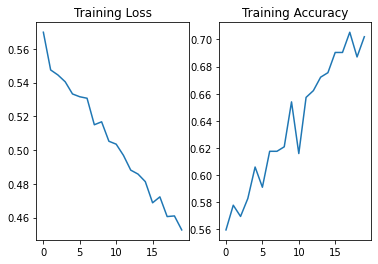

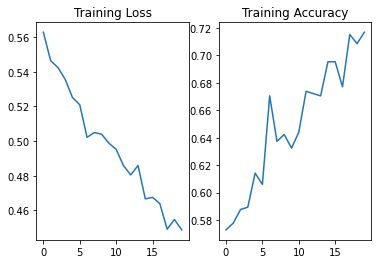

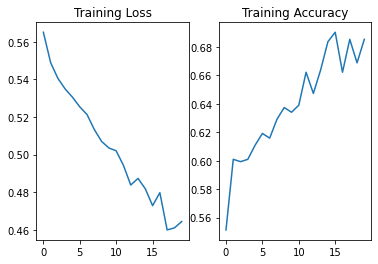

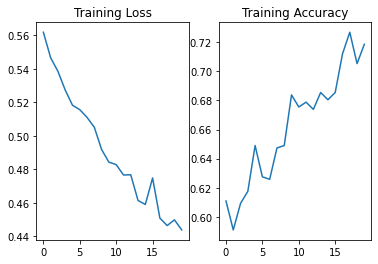

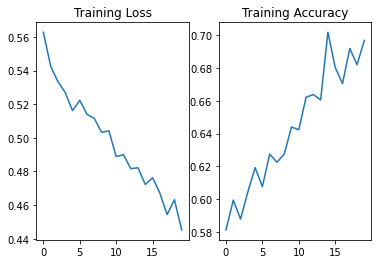

In [ ]:
GCN_accuracies = []
GCN_losses = []
GCN_train_accuracies = []

for i in range(5):
    GCN_model = GCN(dimH = dataset[0].x.shape[1], num_classes = 2, hidden_dim = 128, num_layers = 5)

    print("Number of Parameters: ", sum(p.numel() for p in GCN_model.parameters())//1000, "k")
    loses, training_acc, accuracy = full_baseline_model(GCN_model, dataset, epochs = 20)
    GCN_accuracies.append(accuracy)
    GCN_losses.append(loses)
    GCN_train_accuracies.append(training_acc)

print("GCN Average Test Accuracy: ", sum(GCN_accuracies)/len(GCN_accuracies))
print("Standard Deviation: ", np.std(GCN_accuracies))


# take the mean of the losses
GCN_losses = torch.mean(torch.tensor(GCN_losses), axis=0)

# take the mean of the training accuracies
GCN_train_accuracies = torch.mean(torch.tensor(GCN_train_accuracies), axis=0)


Number of Parameters:  40 k
Epoch:  0 Loss:  0.5898734791568978
Training Accuracy:  0.5645695364238411 

Epoch:  1 Loss:  0.5744903365041686
Training Accuracy:  0.5695364238410596 

Epoch:  2 Loss:  0.5570509318242628
Training Accuracy:  0.5645695364238411 

Epoch:  3 Loss:  0.5484131561523234
Training Accuracy:  0.5811258278145696 

Epoch:  4 Loss:  0.5499358474616967
Training Accuracy:  0.5844370860927153 

Epoch:  5 Loss:  0.5568645641148563
Training Accuracy:  0.5629139072847682 

Epoch:  6 Loss:  0.5485925429830791
Training Accuracy:  0.5943708609271523 

Epoch:  7 Loss:  0.5514294290865855
Training Accuracy:  0.5745033112582781 

Epoch:  8 Loss:  0.5413401211419749
Training Accuracy:  0.6109271523178808 

Epoch:  9 Loss:  0.5497396958095057
Training Accuracy:  0.597682119205298 

Epoch:  10 Loss:  0.5430439496954913
Training Accuracy:  0.5877483443708609 

Epoch:  11 Loss:  0.5440584598552614
Training Accuracy:  0.6059602649006622 

Epoch:  12 Loss:  0.5448570374064344
Training A

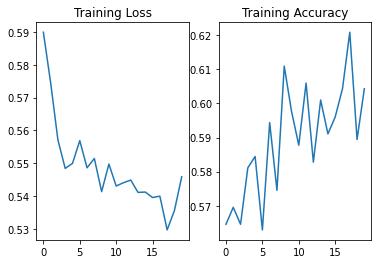

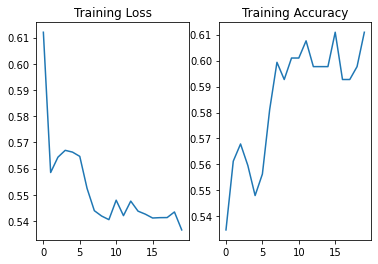

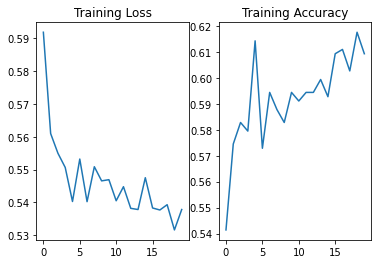

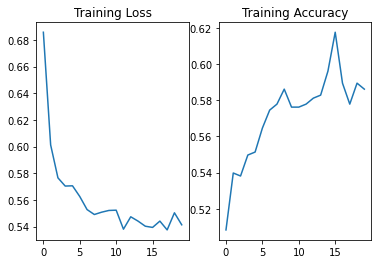

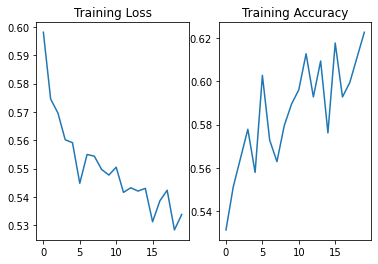

In [ ]:
GAT_accuracies = []
GAT_losses = []
GAT_train_accuracies = []

for i in range(5):
    GAT_model = GAT(dimH = dataset[0].x.shape[1])

    print("Number of Parameters: ", sum(p.numel() for p in GAT_model.parameters())//1000, "k")
    losses, training_acc, accuracy = full_baseline_model(GAT_model, dataset, epochs = 20)
    GAT_accuracies.append(accuracy)
    GAT_losses.append(losses)
    GAT_train_accuracies.append(training_acc)

print("GAT Average Test Accuracy: ", sum(GAT_accuracies)/len(GAT_accuracies))
print("Standard Deviation: ", np.std(GAT_accuracies))


# take the mean of the losses
GAT_losses = torch.mean(torch.tensor(GAT_losses), axis=0)

# take the mean of the training accuracies
GAT_train_accuracies = torch.mean(torch.tensor(GAT_train_accuracies), axis=0)



Number of Parameters:  51 k
Epoch:  0 Loss:  0.571985292716553
Training Accuracy:  0.5447019867549668 

Epoch:  1 Loss:  0.5538134926920215
Training Accuracy:  0.6043046357615894 

Epoch:  2 Loss:  0.5427759906089811
Training Accuracy:  0.5960264900662252 

Epoch:  3 Loss:  0.5391437060657948
Training Accuracy:  0.6125827814569537 

Epoch:  4 Loss:  0.5140662669603314
Training Accuracy:  0.6390728476821192 

Epoch:  5 Loss:  0.5230484773163442
Training Accuracy:  0.6423841059602649 

Epoch:  6 Loss:  0.5074241833475531
Training Accuracy:  0.652317880794702 

Epoch:  7 Loss:  0.5022614586940676
Training Accuracy:  0.6456953642384106 

Epoch:  8 Loss:  0.48453454658507356
Training Accuracy:  0.6688741721854304 

Epoch:  9 Loss:  0.4793829310724817
Training Accuracy:  0.6920529801324503 

Epoch:  10 Loss:  0.4759608878207112
Training Accuracy:  0.6870860927152318 

Epoch:  11 Loss:  0.47395068156242215
Training Accuracy:  0.6903973509933775 

Epoch:  12 Loss:  0.46638611159114923
Training

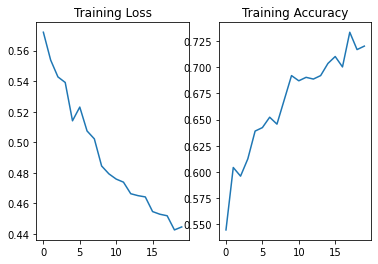

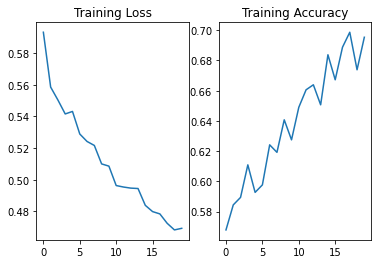

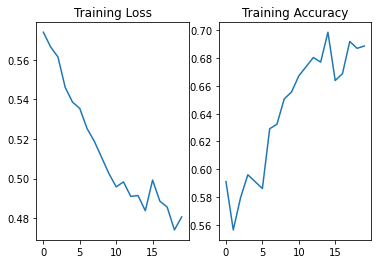

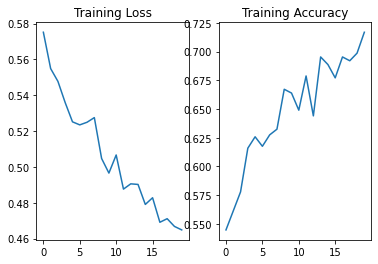

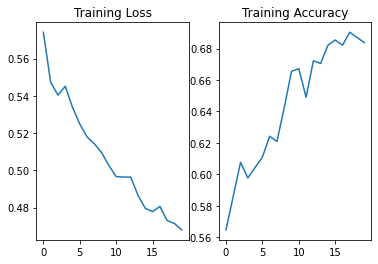

In [ ]:
SAGE_accuracies = []
SAGE_losses = []
SAGE_train_accuracies = []

for i in range(5):
  
    # forward pass of the SAGE model
    SAGE_model = SAGE(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=100)

    print("Number of Parameters: ", sum(p.numel() for p in SAGE_model.parameters())//1000, "k")
    loses, train_acc, accuracy = full_baseline_model(SAGE_model, dataset, epochs = 20)
    SAGE_accuracies.append(accuracy)
    SAGE_losses.append(loses)
    SAGE_train_accuracies.append(train_acc)
    

print("SAGE Average Test Accuracy: ", sum(SAGE_accuracies)/len(SAGE_accuracies))
print("Standard Deviation: ", np.std(SAGE_accuracies))

# take the mean of the losses
SAGE_losses = torch.mean(torch.tensor(SAGE_losses), axis=0)

# take the mean of the training accuracies
SAGE_train_accuracies = torch.mean(torch.tensor(SAGE_train_accuracies), axis=0)


Number of Parameters:  56 k
Epoch:  0 Loss:  0.8892147426463946
Training Accuracy:  0.5844370860927153 

Epoch:  1 Loss:  0.698665577848515
Training Accuracy:  0.6374172185430463 

Epoch:  2 Loss:  0.6690246112523844
Training Accuracy:  0.6357615894039735 

Epoch:  3 Loss:  0.6311185968607552
Training Accuracy:  0.6738410596026491 

Epoch:  4 Loss:  0.5901788451893101
Training Accuracy:  0.6688741721854304 

Epoch:  5 Loss:  0.5509399465371013
Training Accuracy:  0.6738410596026491 

Epoch:  6 Loss:  0.5336053661487226
Training Accuracy:  0.6920529801324503 

Epoch:  7 Loss:  0.5627144577888117
Training Accuracy:  0.6970198675496688 

Epoch:  8 Loss:  0.4969249095306695
Training Accuracy:  0.695364238410596 

Epoch:  9 Loss:  0.4833711389373377
Training Accuracy:  0.7317880794701986 

Epoch:  10 Loss:  0.49590081929412405
Training Accuracy:  0.7086092715231788 

Epoch:  11 Loss:  0.5170934289871227
Training Accuracy:  0.7201986754966887 

Epoch:  12 Loss:  0.4741589333576803
Training A

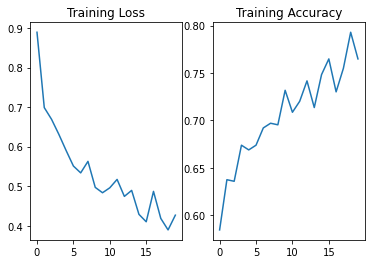

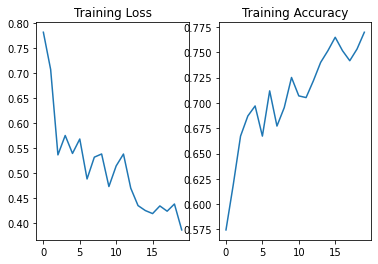

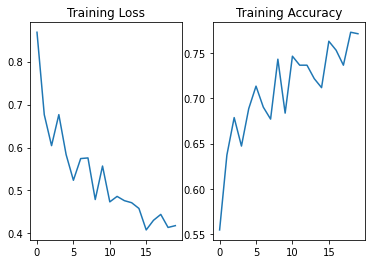

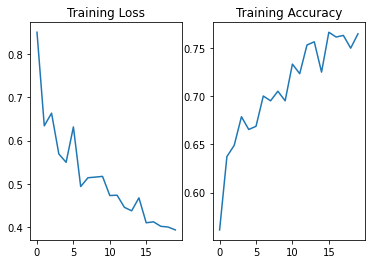

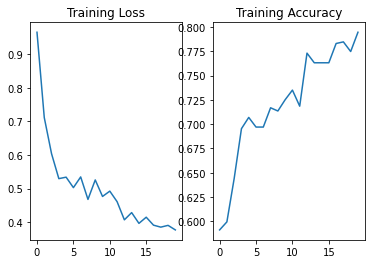

In [ ]:
GIN_accuracies = []
GIN_losses = []
GIN_train_accuracies = []

for i in range(5):
  
    GIN_model = GIN(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=128)

    print("Number of Parameters: ", sum(p.numel() for p in GIN_model.parameters())//1000, "k")
    loss, train_acc, accuracy = full_baseline_model(GIN_model, dataset, epochs = 20)
    GIN_accuracies.append(accuracy)
    GIN_losses.append(loss)
    GIN_train_accuracies.append(train_acc)

print("GIN Average Test Accuracy: ", sum(GIN_accuracies)/len(GIN_accuracies))
print("Standard Deviation: ", np.std(GIN_accuracies))

# take the mean of the losses
GIN_losses = torch.mean(torch.tensor(GIN_losses), axis=0)

# take the mean of the training accuracies
GIN_train_accuracies = torch.mean(torch.tensor(GIN_train_accuracies), axis=0)

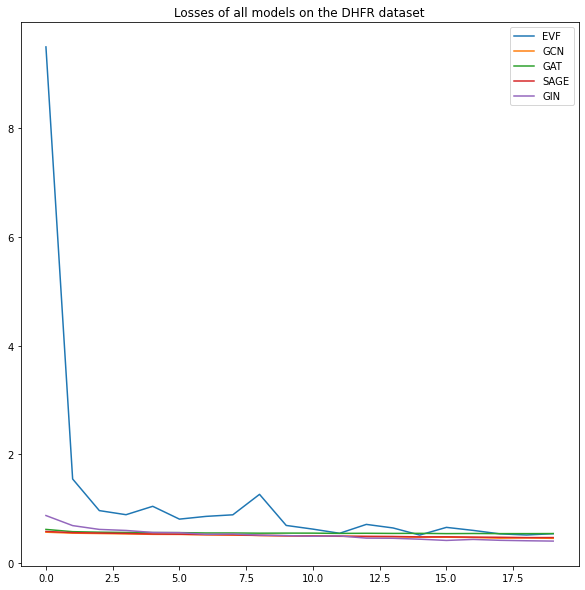

In [ ]:
# plot the losses of all models on the DHFR dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_losses, label='EVF')
plt.plot(GCN_losses, label='GCN')
plt.plot(GAT_losses, label='GAT')
plt.plot(SAGE_losses, label='SAGE')
plt.plot(GIN_losses, label='GIN')

plt.legend()

plt.title("Losses of all models on the DHFR dataset")

plt.show()


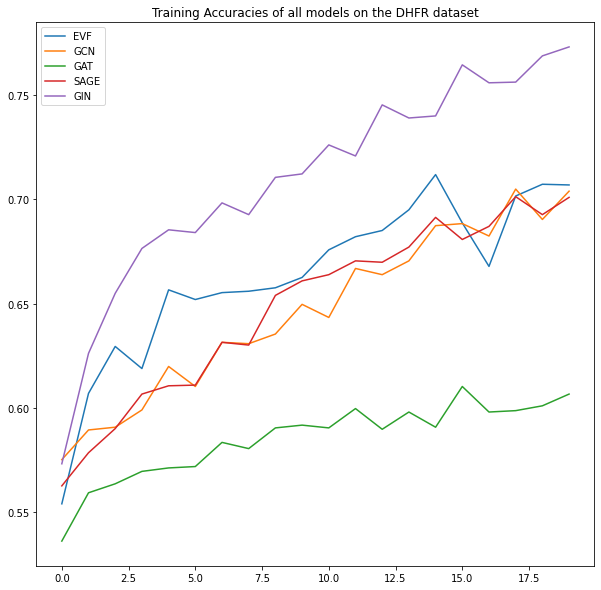

In [ ]:
# plot the training accuracies of all models on the DHFR dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_train_accuracies, label='EVF')
plt.plot(GCN_train_accuracies, label='GCN')
plt.plot(GAT_train_accuracies, label='GAT')
plt.plot(SAGE_train_accuracies, label='SAGE')
plt.plot(GIN_train_accuracies, label='GIN')

plt.legend()

plt.title("Training Accuracies of all models on the DHFR dataset")

plt.show()


In [ ]:
# plot the average accuracies and standard deviations on the DHFR dataset in a table
print("Average Test Accuracies: ")
print("EVF: ", sum(EVF_accuracies)/len(EVF_accuracies), "Standard Deviation: ", np.std(EVF_accuracies))
print("GCN: ", sum(GCN_accuracies)/len(GCN_accuracies), "Standard Deviation: ", np.std(GCN_accuracies))
print("GAT: ", sum(GAT_accuracies)/len(GAT_accuracies), "Standard Deviation: ", np.std(GAT_accuracies))
print("SAGE: ", sum(SAGE_accuracies)/len(SAGE_accuracies), "Standard Deviation: ", np.std(SAGE_accuracies))
print("GIN: ", sum(GIN_accuracies)/len(GIN_accuracies), "Standard Deviation: ", np.std(GIN_accuracies))




Average Test Accuracies: 
EVF:  0.7697368421052632 Standard Deviation:  0.03744802492304662
GCN:  0.6763157894736842 Standard Deviation:  0.04769623410629434
GAT:  0.5947368421052632 Standard Deviation:  0.024118819447135998
SAGE:  0.6578947368421053 Standard Deviation:  0.019954935379083008
GIN:  0.7171052631578947 Standard Deviation:  0.10418859418331132


### COX Model Testing

In [ ]:
dataset = TUDataset(root='/tmp/COX2', name='COX2', use_node_attr=True)

# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

# plot the molecule
fig = plot_molecule(tdata[0])

fig.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/3348049437.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/3348049437.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Number of Parameters:  50 k
Epoch:  0 Loss:  1.1853775143944583
Training Accuracy:  0.6970509383378016 

Epoch:  1 Loss:  0.5241131015645359
Training Accuracy:  0.7050938337801609 

Epoch:  2 Loss:  0.3895451340971788
Training Accuracy:  0.7667560321715817 

Epoch:  3 Loss:  0.3441167122469468
Training Accuracy:  0.7855227882037533 

Epoch:  4 Loss:  0.35170457300150715
Training Accuracy:  0.7721179624664879 

Epoch:  5 Loss:  0.322596330688925
Training Accuracy:  0.8042895442359249 

Epoch:  6 Loss:  0.3019431010822169
Training Accuracy:  0.8123324396782842 

Epoch:  7 Loss:  0.3025889891799784
Training Accuracy:  0.8230563002680965 

Epoch:  8 Loss:  0.2782711661091804
Training Accuracy:  0.8284182305630027 

Epoch:  9 Loss:  0.2801380548572904
Training Accuracy:  0.8418230563002681 

Epoch:  10 Loss:  0.27965773494357515
Training Accuracy:  0.8123324396782842 

Epoch:  11 Loss:  0.24329204677044047
Training Accuracy:  0.8525469168900804 

Epoch:  12 Loss:  0.24294544222919676
Traini

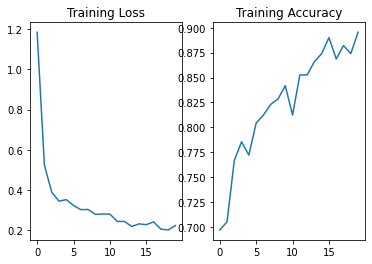

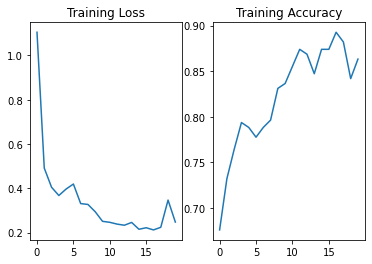

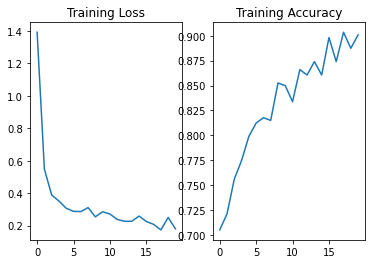

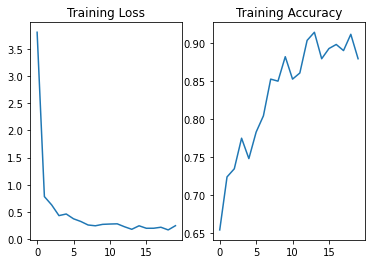

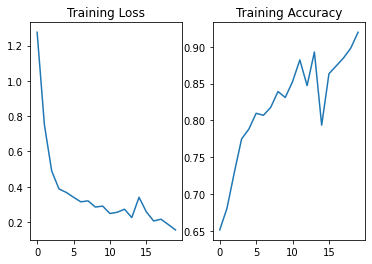

In [ ]:
EVF_accuracies = []
EVF_losses = []
EVF_train_accuracies = []

for i in range(5):
    # construct evf mode
    model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 8, evf_hidden_dim= 64, classifier_hidden_dim=16)

    # initialise cross-entropy loss and adam optimizer
    criterion = nn.CrossEntropyLoss()

    # build an optimizer on evf and classifer parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # plot number of parameters in model
    print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

    # train the model
    model, all_loses, all_accuracies, test_accuracy = train_model(model, criterion, optimizer, tdata, epochs=20, batch_size=5)

    EVF_accuracies.append(test_accuracy)
    EVF_losses.append(all_loses)
    EVF_train_accuracies.append(all_accuracies)

print("Average Test Accuracy: ", sum(accuracies)/len(accuracies))
print("Standard Deviation: ", np.std(accuracies))


# take the mean of the losses
EVF_losses = torch.mean(torch.tensor(EVF_losses), axis=0)

# take the mean of the training accuracies
EVF_train_accuracies = torch.mean(torch.tensor(EVF_train_accuracies), axis=0)


### COX2 Baseline Testing

In [ ]:
# make a new TU dataset with position features
dataset = TUDataset(root='/tmp/COX2', name='COX2', use_node_attr=False)

Number of Parameters:  54 k
Epoch:  0 Loss:  0.4529853798768122
Training Accuracy:  0.7667560321715817 

Epoch:  1 Loss:  0.44492634683368804
Training Accuracy:  0.7587131367292225 

Epoch:  2 Loss:  0.42523539795418624
Training Accuracy:  0.7667560321715817 

Epoch:  3 Loss:  0.423843533343115
Training Accuracy:  0.7667560321715817 

Epoch:  4 Loss:  0.40595597891850954
Training Accuracy:  0.774798927613941 

Epoch:  5 Loss:  0.4096702635926404
Training Accuracy:  0.7667560321715817 

Epoch:  6 Loss:  0.3995863434916454
Training Accuracy:  0.774798927613941 

Epoch:  7 Loss:  0.40926608374657414
Training Accuracy:  0.7667560321715817 

Epoch:  8 Loss:  0.3968874771363347
Training Accuracy:  0.7694369973190348 

Epoch:  9 Loss:  0.3840274624167533
Training Accuracy:  0.7855227882037533 

Epoch:  10 Loss:  0.38545070069680504
Training Accuracy:  0.7855227882037533 

Epoch:  11 Loss:  0.37835107453175415
Training Accuracy:  0.7774798927613941 

Epoch:  12 Loss:  0.37892328472349324
Train

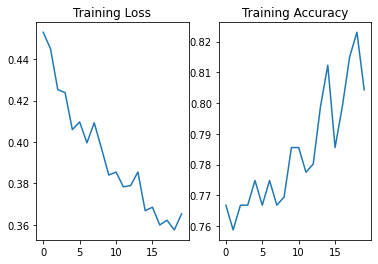

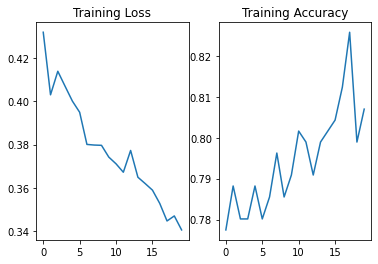

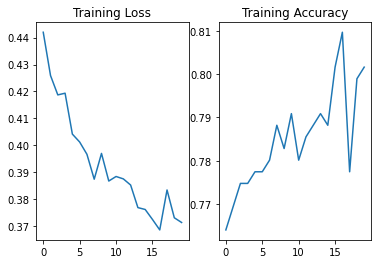

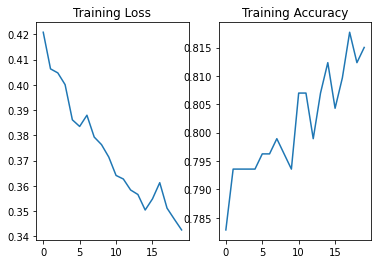

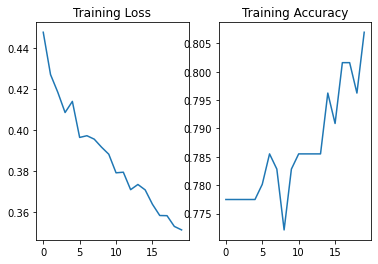

In [ ]:
GCN_accuracies = []
GCN_losses = []
GCN_train_accuracies = []

for i in range(5):
    GCN_model = GCN(dimH = dataset[0].x.shape[1], num_classes = 2, hidden_dim = 128, num_layers = 5)

    print("Number of Parameters: ", sum(p.numel() for p in GCN_model.parameters())//1000, "k")
    loses, training_acc, accuracy = full_baseline_model(GCN_model, dataset, epochs = 20)
    GCN_accuracies.append(accuracy)
    GCN_losses.append(loses)
    GCN_train_accuracies.append(training_acc)

print("GCN Average Test Accuracy: ", sum(GCN_accuracies)/len(GCN_accuracies))
print("Standard Deviation: ", np.std(GCN_accuracies))


# take the mean of the losses
GCN_losses = torch.mean(torch.tensor(GCN_losses), axis=0)

# take the mean of the training accuracies
GCN_train_accuracies = torch.mean(torch.tensor(GCN_train_accuracies), axis=0)


Number of Parameters:  38 k
Epoch:  0 Loss:  0.48412411294805735
Training Accuracy:  0.7238605898123325 

Epoch:  1 Loss:  0.45874264247603797
Training Accuracy:  0.7533512064343163 

Epoch:  2 Loss:  0.45536765279707037
Training Accuracy:  0.7613941018766756 

Epoch:  3 Loss:  0.4726363510068913
Training Accuracy:  0.7479892761394102 

Epoch:  4 Loss:  0.45348581145427785
Training Accuracy:  0.7587131367292225 

Epoch:  5 Loss:  0.4666322482235299
Training Accuracy:  0.7587131367292225 

Epoch:  6 Loss:  0.43224334702438155
Training Accuracy:  0.7721179624664879 

Epoch:  7 Loss:  0.4284932592313346
Training Accuracy:  0.7694369973190348 

Epoch:  8 Loss:  0.4454779654613654
Training Accuracy:  0.774798927613941 

Epoch:  9 Loss:  0.43605301507631
Training Accuracy:  0.7640750670241286 

Epoch:  10 Loss:  0.4291504675510481
Training Accuracy:  0.7774798927613941 

Epoch:  11 Loss:  0.4304120387499095
Training Accuracy:  0.7694369973190348 

Epoch:  12 Loss:  0.4411511218984964
Trainin

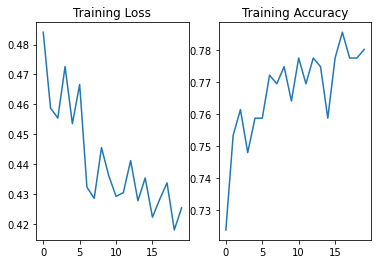

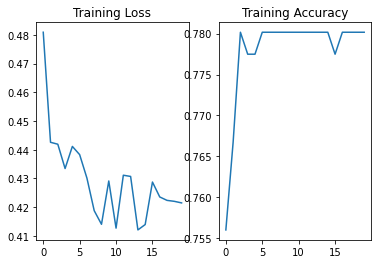

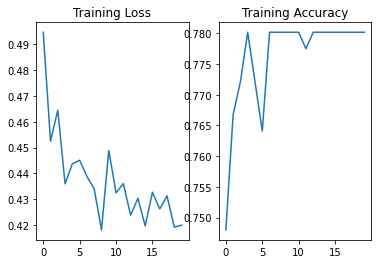

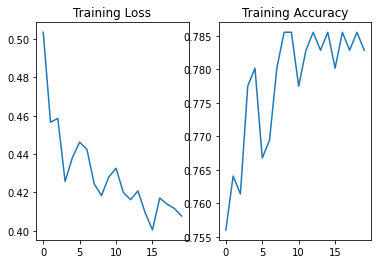

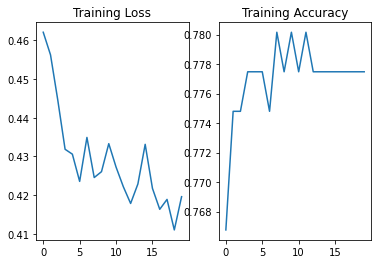

In [ ]:
GAT_accuracies = []
GAT_losses = []
GAT_train_accuracies = []

for i in range(5):
    GAT_model = GAT(dimH = dataset[0].x.shape[1])

    print("Number of Parameters: ", sum(p.numel() for p in GAT_model.parameters())//1000, "k")
    losses, training_acc, accuracy = full_baseline_model(GAT_model, dataset, epochs = 20)
    GAT_accuracies.append(accuracy)
    GAT_losses.append(losses)
    GAT_train_accuracies.append(training_acc)

print("GAT Average Test Accuracy: ", sum(GAT_accuracies)/len(GAT_accuracies))
print("Standard Deviation: ", np.std(GAT_accuracies))


# take the mean of the losses
GAT_losses = torch.mean(torch.tensor(GAT_losses), axis=0)

# take the mean of the training accuracies
GAT_train_accuracies = torch.mean(torch.tensor(GAT_train_accuracies), axis=0)



Number of Parameters:  47 k
Epoch:  0 Loss:  0.49897919440561234
Training Accuracy:  0.7640750670241286 

Epoch:  1 Loss:  0.42979317803007633
Training Accuracy:  0.774798927613941 

Epoch:  2 Loss:  0.4412971769222228
Training Accuracy:  0.7721179624664879 

Epoch:  3 Loss:  0.4280711366641445
Training Accuracy:  0.7774798927613941 

Epoch:  4 Loss:  0.4269551489685664
Training Accuracy:  0.7667560321715817 

Epoch:  5 Loss:  0.41426894247404256
Training Accuracy:  0.7855227882037533 

Epoch:  6 Loss:  0.40049422398305295
Training Accuracy:  0.7828418230563002 

Epoch:  7 Loss:  0.40439845509508054
Training Accuracy:  0.7882037533512064 

Epoch:  8 Loss:  0.4032363735968985
Training Accuracy:  0.7908847184986595 

Epoch:  9 Loss:  0.3899199351333321
Training Accuracy:  0.7935656836461126 

Epoch:  10 Loss:  0.3851053067692406
Training Accuracy:  0.7828418230563002 

Epoch:  11 Loss:  0.39562144205053945
Training Accuracy:  0.7989276139410187 

Epoch:  12 Loss:  0.384231450618494
Train

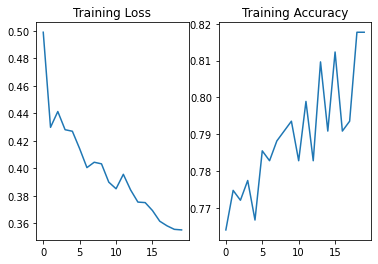

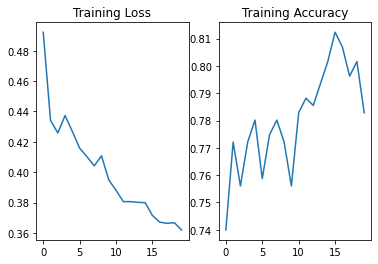

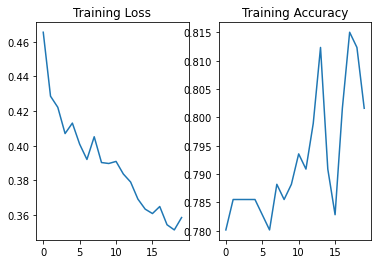

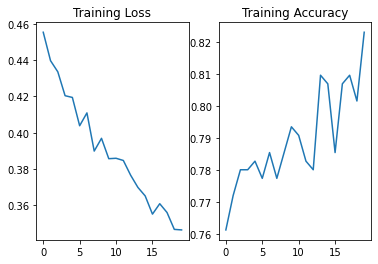

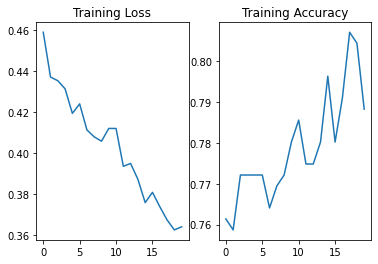

In [ ]:
SAGE_accuracies = []
SAGE_losses = []
SAGE_train_accuracies = []

for i in range(5):
  
    # forward pass of the SAGE model
    SAGE_model = SAGE(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=100)

    print("Number of Parameters: ", sum(p.numel() for p in SAGE_model.parameters())//1000, "k")
    loses, train_acc, accuracy = full_baseline_model(SAGE_model, dataset, epochs = 20)
    SAGE_accuracies.append(accuracy)
    SAGE_losses.append(loses)
    SAGE_train_accuracies.append(train_acc)
    

print("SAGE Average Test Accuracy: ", sum(SAGE_accuracies)/len(SAGE_accuracies))
print("Standard Deviation: ", np.std(SAGE_accuracies))

# take the mean of the losses
SAGE_losses = torch.mean(torch.tensor(SAGE_losses), axis=0)

# take the mean of the training accuracies
SAGE_train_accuracies = torch.mean(torch.tensor(SAGE_train_accuracies), axis=0)


Number of Parameters:  54 k
Epoch:  0 Loss:  0.6551484433240368
Training Accuracy:  0.7158176943699732 

Epoch:  1 Loss:  0.6043765838706056
Training Accuracy:  0.7131367292225201 

Epoch:  2 Loss:  0.5389173496639668
Training Accuracy:  0.7479892761394102 

Epoch:  3 Loss:  0.5081242717709137
Training Accuracy:  0.7479892761394102 

Epoch:  4 Loss:  0.42074217807073533
Training Accuracy:  0.7908847184986595 

Epoch:  5 Loss:  0.42191460802888137
Training Accuracy:  0.7989276139410187 

Epoch:  6 Loss:  0.4519450869825975
Training Accuracy:  0.7774798927613941 

Epoch:  7 Loss:  0.4088552501582657
Training Accuracy:  0.7989276139410187 

Epoch:  8 Loss:  0.4461733923681582
Training Accuracy:  0.774798927613941 

Epoch:  9 Loss:  0.4375580110792776
Training Accuracy:  0.7935656836461126 

Epoch:  10 Loss:  0.4161955860570984
Training Accuracy:  0.774798927613941 

Epoch:  11 Loss:  0.3693592557466944
Training Accuracy:  0.8337801608579088 

Epoch:  12 Loss:  0.4302605857237898
Training 

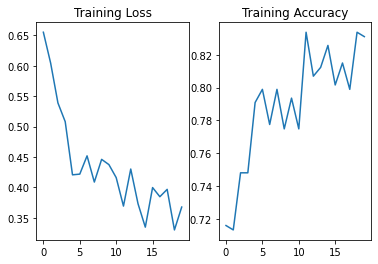

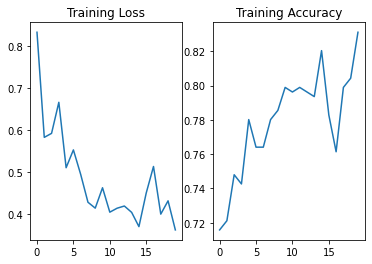

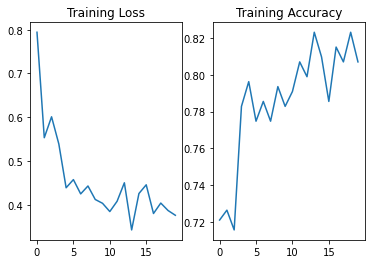

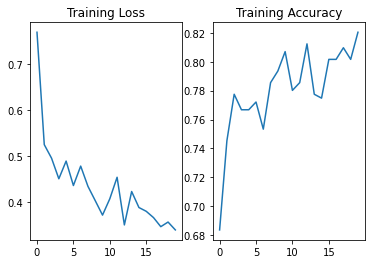

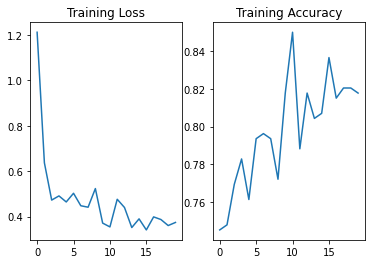

In [ ]:
GIN_accuracies = []
GIN_losses = []
GIN_train_accuracies = []

for i in range(5):
  
    GIN_model = GIN(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=128)

    print("Number of Parameters: ", sum(p.numel() for p in GIN_model.parameters())//1000, "k")
    loss, train_acc, accuracy = full_baseline_model(GIN_model, dataset, epochs = 20)
    GIN_accuracies.append(accuracy)
    GIN_losses.append(loss)
    GIN_train_accuracies.append(train_acc)

print("GIN Average Test Accuracy: ", sum(GIN_accuracies)/len(GIN_accuracies))
print("Standard Deviation: ", np.std(GIN_accuracies))

# take the mean of the losses
GIN_losses = torch.mean(torch.tensor(GIN_losses), axis=0)

# take the mean of the training accuracies
GIN_train_accuracies = torch.mean(torch.tensor(GIN_train_accuracies), axis=0)

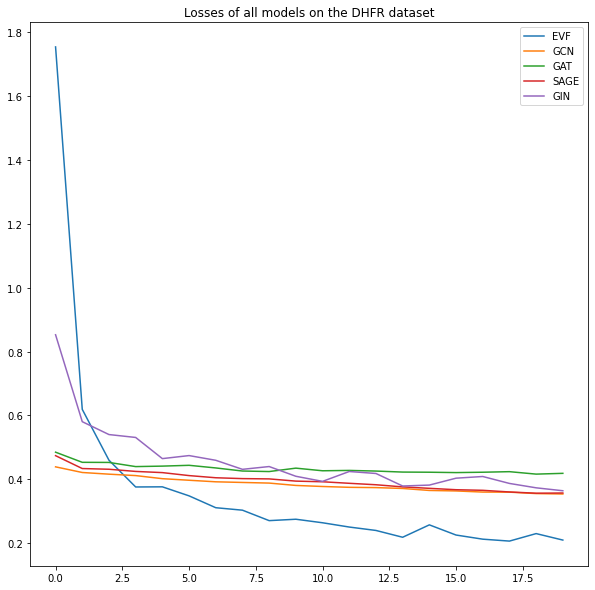

In [ ]:
# plot the losses of all models on the COX2 dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_losses, label='EVF')
plt.plot(GCN_losses, label='GCN')
plt.plot(GAT_losses, label='GAT')
plt.plot(SAGE_losses, label='SAGE')
plt.plot(GIN_losses, label='GIN')

plt.legend()

plt.title("Losses of all models on the DHFR dataset")

plt.show()


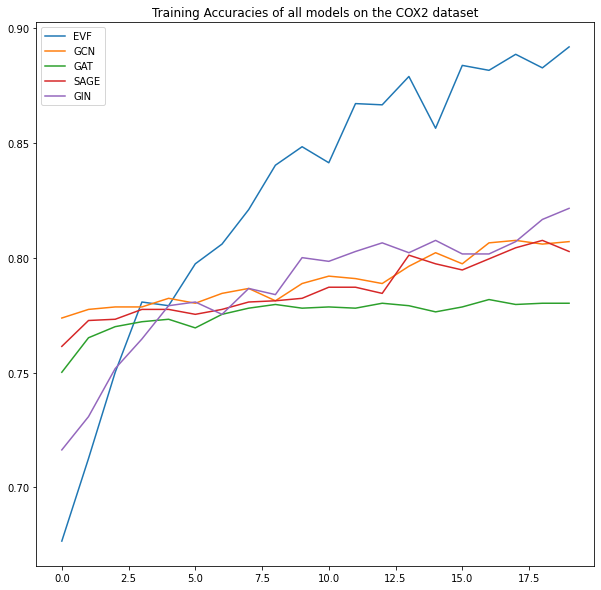

In [ ]:
# plot the training accuracies of all models on the COX2 dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_train_accuracies, label='EVF')
plt.plot(GCN_train_accuracies, label='GCN')
plt.plot(GAT_train_accuracies, label='GAT')
plt.plot(SAGE_train_accuracies, label='SAGE')
plt.plot(GIN_train_accuracies, label='GIN')

plt.legend()

plt.title("Training Accuracies of all models on the COX2 dataset")

plt.show()


In [ ]:
# plot the average accuracies and standard deviations on the COX2 dataset in a table
print("Average Test Accuracies: ")
print("EVF: ", sum(EVF_accuracies)/len(EVF_accuracies), "Standard Deviation: ", np.std(EVF_accuracies))
print("GCN: ", sum(GCN_accuracies)/len(GCN_accuracies), "Standard Deviation: ", np.std(GCN_accuracies))
print("GAT: ", sum(GAT_accuracies)/len(GAT_accuracies), "Standard Deviation: ", np.std(GAT_accuracies))
print("SAGE: ", sum(SAGE_accuracies)/len(SAGE_accuracies), "Standard Deviation: ", np.std(SAGE_accuracies))
print("GIN: ", sum(GIN_accuracies)/len(GIN_accuracies), "Standard Deviation: ", np.std(GIN_accuracies))

Average Test Accuracies: 
EVF:  0.8170212765957446 Standard Deviation:  0.04276542817498252
GCN:  0.8021276595744681 Standard Deviation:  0.02570860845445652
GAT:  0.7872340425531915 Standard Deviation:  0.011653671436280126
SAGE:  0.8170212765957446 Standard Deviation:  0.017021276595744688
GIN:  0.7574468085106383 Standard Deviation:  0.04169344243035195


### BZR Model Testing

In [54]:
dataset = TUDataset(root='/tmp/BZR', name='BZR', use_node_attr=True)

# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    # mean center the positional features
    Z = Z - torch.mean(Z, axis=0)
    # normalise the positional features
    Z = Z/torch.max(Z)
    
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

# plot the molecule
fig = plot_molecule(tdata[0])

fig.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/3519204604.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_28722/3519204604.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Number of Parameters:  50 k
Epoch:  0 Loss:  1.9862404956811284
Training Accuracy:  0.6759259259259259 

Epoch:  1 Loss:  0.4369210938129923
Training Accuracy:  0.8055555555555556 

Epoch:  2 Loss:  0.324382518558897
Training Accuracy:  0.8117283950617284 

Epoch:  3 Loss:  0.2957299096916358
Training Accuracy:  0.8209876543209876 

Epoch:  4 Loss:  0.36178720807161063
Training Accuracy:  0.808641975308642 

Epoch:  5 Loss:  0.34458630366763904
Training Accuracy:  0.808641975308642 

Epoch:  6 Loss:  0.3399026406319636
Training Accuracy:  0.8179012345679012 

Epoch:  7 Loss:  0.29381805280386897
Training Accuracy:  0.8209876543209876 

Epoch:  8 Loss:  0.27995063273442305
Training Accuracy:  0.8333333333333334 

Epoch:  9 Loss:  0.266943610584604
Training Accuracy:  0.8271604938271605 

Epoch:  10 Loss:  0.24468116463798445
Training Accuracy:  0.8549382716049383 

Epoch:  11 Loss:  0.23972508362288958
Training Accuracy:  0.8672839506172839 

Epoch:  12 Loss:  0.23046018444278238
Traini

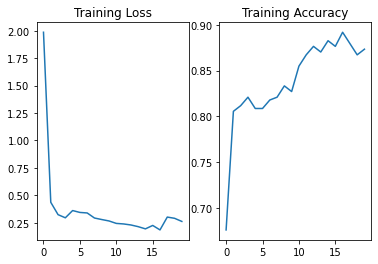

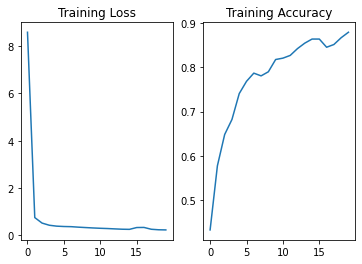

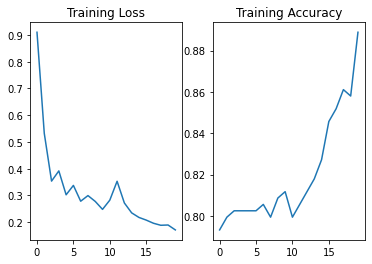

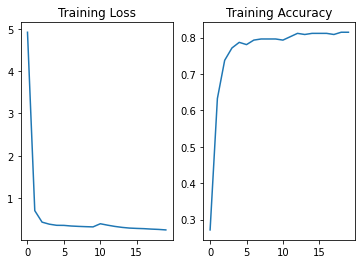

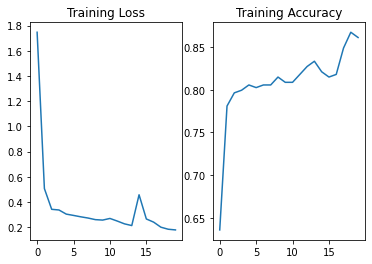

In [57]:
EVF_accuracies = []
EVF_losses = []
EVF_train_accuracies = []

for i in range(5):
    # construct evf mode
    model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 64, classifier_hidden_dim=16)

    # initialise cross-entropy loss and adam optimizer
    criterion = nn.CrossEntropyLoss()

    # build an optimizer on evf and classifer parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # plot number of parameters in model
    print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

    # train the model
    model, all_loses, all_accuracies, test_accuracy = train_model(model, criterion, optimizer, tdata, epochs=20, batch_size=5)

    EVF_accuracies.append(test_accuracy)
    EVF_losses.append(all_loses)
    EVF_train_accuracies.append(all_accuracies)

print("Average Test Accuracy: ", sum(EVF_accuracies)/len(EVF_accuracies))
print("Standard Deviation: ", np.std(EVF_accuracies))


# take the mean of the losses
EVF_losses = torch.mean(torch.tensor(EVF_losses), axis=0)

# take the mean of the training accuracies
EVF_train_accuracies = torch.mean(torch.tensor(EVF_train_accuracies), axis=0)


### BZR Baseline Testing

In [ ]:
# make a new TU dataset with position features
dataset = TUDataset(root='/tmp/BZR', name='BZR', use_node_attr=False)

Number of Parameters:  56 k
Epoch:  0 Loss:  0.4164310305942724
Training Accuracy:  0.7777777777777778 

Epoch:  1 Loss:  0.3918978012454363
Training Accuracy:  0.7839506172839507 

Epoch:  2 Loss:  0.3699431042773304
Training Accuracy:  0.7870370370370371 

Epoch:  3 Loss:  0.3635962355858934
Training Accuracy:  0.7932098765432098 

Epoch:  4 Loss:  0.3518662272495459
Training Accuracy:  0.8209876543209876 

Epoch:  5 Loss:  0.34592960826351227
Training Accuracy:  0.8117283950617284 

Epoch:  6 Loss:  0.35193778018030214
Training Accuracy:  0.8179012345679012 

Epoch:  7 Loss:  0.3354965670229752
Training Accuracy:  0.8333333333333334 

Epoch:  8 Loss:  0.3316680799321743
Training Accuracy:  0.8302469135802469 

Epoch:  9 Loss:  0.3210738683645441
Training Accuracy:  0.8055555555555556 

Epoch:  10 Loss:  0.32474470671954747
Training Accuracy:  0.8240740740740741 

Epoch:  11 Loss:  0.3142822489780546
Training Accuracy:  0.8271604938271605 

Epoch:  12 Loss:  0.3179211955889772
Traini

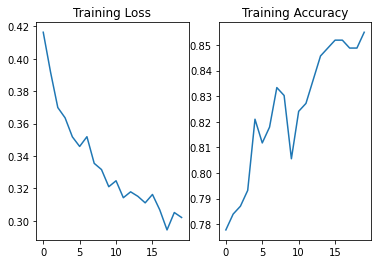

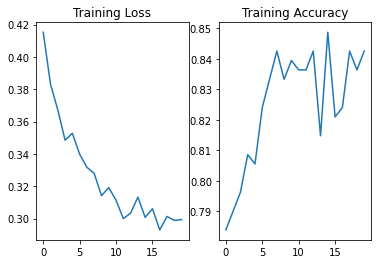

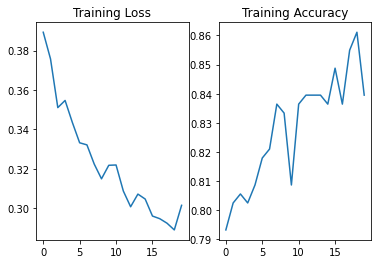

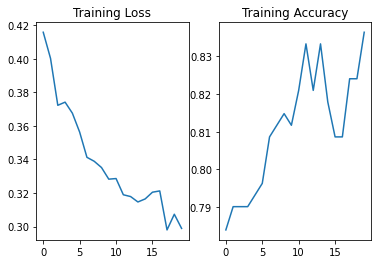

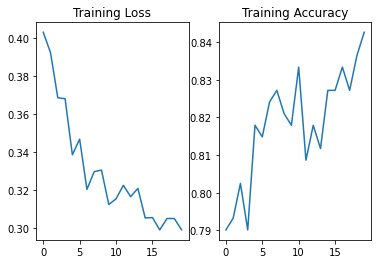

In [ ]:
GCN_accuracies = []
GCN_losses = []
GCN_train_accuracies = []

for i in range(5):
    GCN_model = GCN(dimH = dataset[0].x.shape[1], num_classes = 2, hidden_dim = 128, num_layers = 5)

    print("Number of Parameters: ", sum(p.numel() for p in GCN_model.parameters())//1000, "k")
    loses, training_acc, accuracy = full_baseline_model(GCN_model, dataset, epochs = 20)
    GCN_accuracies.append(accuracy)
    GCN_losses.append(loses)
    GCN_train_accuracies.append(training_acc)

print("GCN Average Test Accuracy: ", sum(GCN_accuracies)/len(GCN_accuracies))
print("Standard Deviation: ", np.std(GCN_accuracies))


# take the mean of the losses
GCN_losses = torch.mean(torch.tensor(GCN_losses), axis=0)

# take the mean of the training accuracies
GCN_train_accuracies = torch.mean(torch.tensor(GCN_train_accuracies), axis=0)


Number of Parameters:  40 k
Epoch:  0 Loss:  0.46737203294020374
Training Accuracy:  0.75 

Epoch:  1 Loss:  0.43610359091127726
Training Accuracy:  0.7808641975308642 

Epoch:  2 Loss:  0.4182140721767037
Training Accuracy:  0.7839506172839507 

Epoch:  3 Loss:  0.4280501921327762
Training Accuracy:  0.7808641975308642 

Epoch:  4 Loss:  0.4134685716925212
Training Accuracy:  0.7870370370370371 

Epoch:  5 Loss:  0.4081661077469219
Training Accuracy:  0.7932098765432098 

Epoch:  6 Loss:  0.40182719707580994
Training Accuracy:  0.7808641975308642 

Epoch:  7 Loss:  0.4201007589329908
Training Accuracy:  0.7746913580246914 

Epoch:  8 Loss:  0.41084910724082113
Training Accuracy:  0.7839506172839507 

Epoch:  9 Loss:  0.40360013968598696
Training Accuracy:  0.7901234567901234 

Epoch:  10 Loss:  0.40791231786579263
Training Accuracy:  0.7901234567901234 

Epoch:  11 Loss:  0.41198675804484036
Training Accuracy:  0.7839506172839507 

Epoch:  12 Loss:  0.3952629542645113
Training Accurac

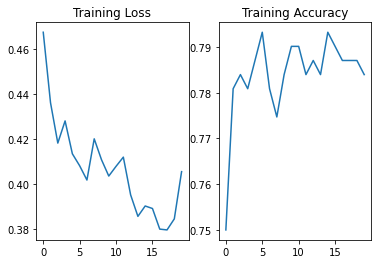

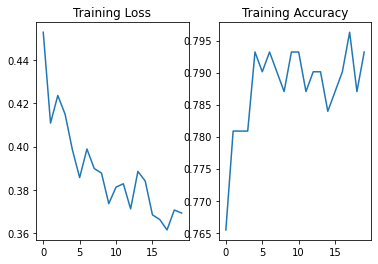

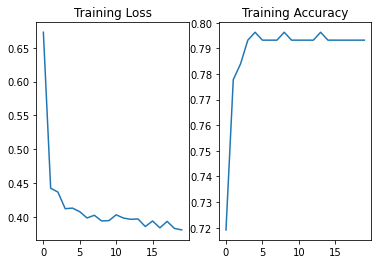

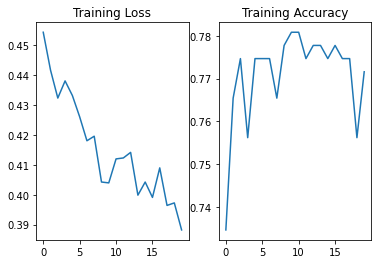

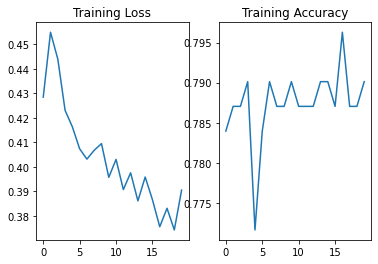

In [ ]:
GAT_accuracies = []
GAT_losses = []
GAT_train_accuracies = []

for i in range(5):
    GAT_model = GAT(dimH = dataset[0].x.shape[1])

    print("Number of Parameters: ", sum(p.numel() for p in GAT_model.parameters())//1000, "k")
    losses, training_acc, accuracy = full_baseline_model(GAT_model, dataset, epochs = 20)
    GAT_accuracies.append(accuracy)
    GAT_losses.append(losses)
    GAT_train_accuracies.append(training_acc)

print("GAT Average Test Accuracy: ", sum(GAT_accuracies)/len(GAT_accuracies))
print("Standard Deviation: ", np.std(GAT_accuracies))


# take the mean of the losses
GAT_losses = torch.mean(torch.tensor(GAT_losses), axis=0)

# take the mean of the training accuracies
GAT_train_accuracies = torch.mean(torch.tensor(GAT_train_accuracies), axis=0)



Number of Parameters:  51 k
Epoch:  0 Loss:  0.43762792632167724
Training Accuracy:  0.7685185185185185 

Epoch:  1 Loss:  0.4156180685593022
Training Accuracy:  0.7746913580246914 

Epoch:  2 Loss:  0.42053814581422894
Training Accuracy:  0.7870370370370371 

Epoch:  3 Loss:  0.413008600105474
Training Accuracy:  0.7870370370370371 

Epoch:  4 Loss:  0.4022299747362181
Training Accuracy:  0.7870370370370371 

Epoch:  5 Loss:  0.3956656703058584
Training Accuracy:  0.7870370370370371 

Epoch:  6 Loss:  0.37933714247228184
Training Accuracy:  0.7901234567901234 

Epoch:  7 Loss:  0.38181034898684346
Training Accuracy:  0.7932098765432098 

Epoch:  8 Loss:  0.36514071760423206
Training Accuracy:  0.7932098765432098 

Epoch:  9 Loss:  0.37221574132549173
Training Accuracy:  0.7962962962962963 

Epoch:  10 Loss:  0.35702711566937745
Training Accuracy:  0.7901234567901234 

Epoch:  11 Loss:  0.34458897782512654
Training Accuracy:  0.7932098765432098 

Epoch:  12 Loss:  0.3489192080002761
Tr

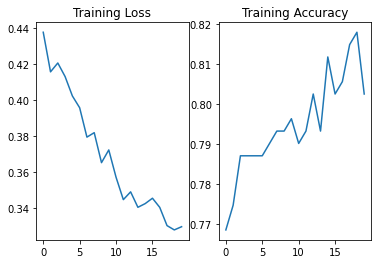

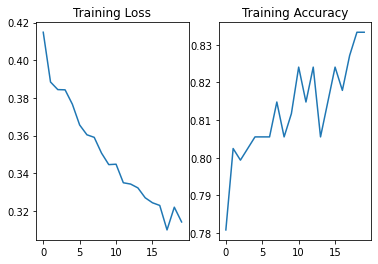

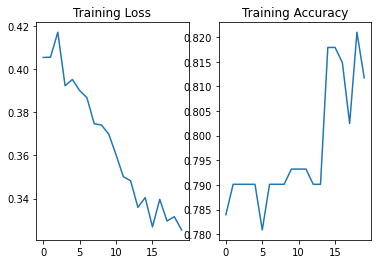

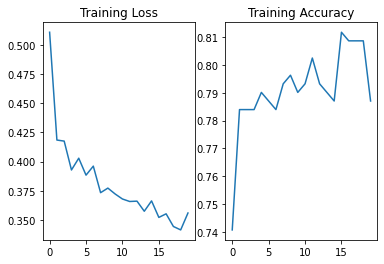

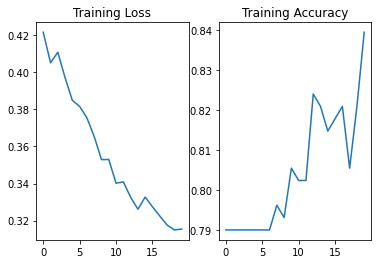

In [ ]:
SAGE_accuracies = []
SAGE_losses = []
SAGE_train_accuracies = []

for i in range(5):
  
    # forward pass of the SAGE model
    SAGE_model = SAGE(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=100)

    print("Number of Parameters: ", sum(p.numel() for p in SAGE_model.parameters())//1000, "k")
    loses, train_acc, accuracy = full_baseline_model(SAGE_model, dataset, epochs = 20)
    SAGE_accuracies.append(accuracy)
    SAGE_losses.append(loses)
    SAGE_train_accuracies.append(train_acc)
    

print("SAGE Average Test Accuracy: ", sum(SAGE_accuracies)/len(SAGE_accuracies))
print("Standard Deviation: ", np.std(SAGE_accuracies))

# take the mean of the losses
SAGE_losses = torch.mean(torch.tensor(SAGE_losses), axis=0)

# take the mean of the training accuracies
SAGE_train_accuracies = torch.mean(torch.tensor(SAGE_train_accuracies), axis=0)


Number of Parameters:  56 k
Epoch:  0 Loss:  0.6303903765944375
Training Accuracy:  0.7469135802469136 

Epoch:  1 Loss:  0.5005388163135932
Training Accuracy:  0.7623456790123457 

Epoch:  2 Loss:  0.4716407630464424
Training Accuracy:  0.7746913580246914 

Epoch:  3 Loss:  0.49535460533837344
Training Accuracy:  0.7685185185185185 

Epoch:  4 Loss:  0.42164112957776795
Training Accuracy:  0.7839506172839507 

Epoch:  5 Loss:  0.41611531928574985
Training Accuracy:  0.8024691358024691 

Epoch:  6 Loss:  0.38512817321417936
Training Accuracy:  0.7777777777777778 

Epoch:  7 Loss:  0.3482635278607334
Training Accuracy:  0.808641975308642 

Epoch:  8 Loss:  0.41465560909235794
Training Accuracy:  0.808641975308642 

Epoch:  9 Loss:  0.3398197476378411
Training Accuracy:  0.8055555555555556 

Epoch:  10 Loss:  0.3145370703628212
Training Accuracy:  0.8364197530864198 

Epoch:  11 Loss:  0.33871388082168785
Training Accuracy:  0.8302469135802469 

Epoch:  12 Loss:  0.3862317467267036
Train

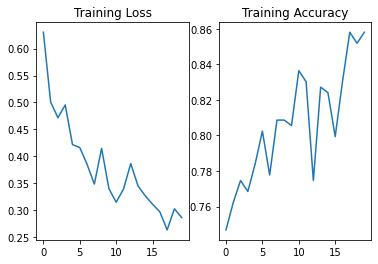

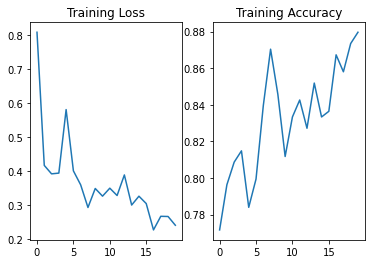

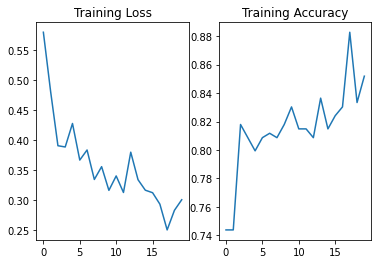

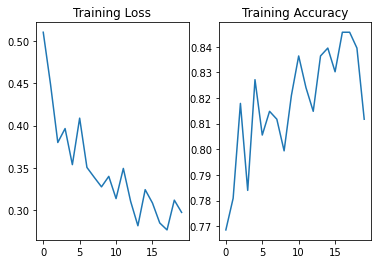

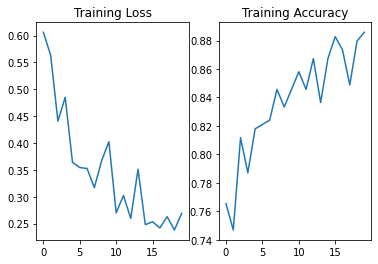

In [ ]:
GIN_accuracies = []
GIN_losses = []
GIN_train_accuracies = []

for i in range(5):
  
    GIN_model = GIN(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=128)

    print("Number of Parameters: ", sum(p.numel() for p in GIN_model.parameters())//1000, "k")
    loss, train_acc, accuracy = full_baseline_model(GIN_model, dataset, epochs = 20)
    GIN_accuracies.append(accuracy)
    GIN_losses.append(loss)
    GIN_train_accuracies.append(train_acc)

print("GIN Average Test Accuracy: ", sum(GIN_accuracies)/len(GIN_accuracies))
print("Standard Deviation: ", np.std(GIN_accuracies))

# take the mean of the losses
GIN_losses = torch.mean(torch.tensor(GIN_losses), axis=0)

# take the mean of the training accuracies
GIN_train_accuracies = torch.mean(torch.tensor(GIN_train_accuracies), axis=0)

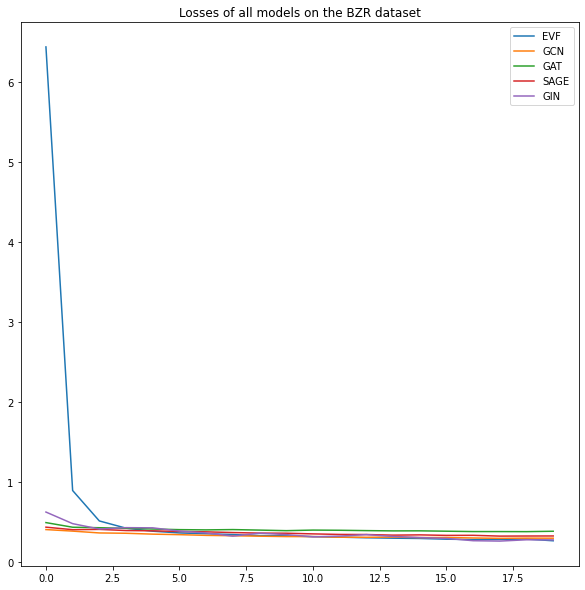

In [ ]:
# plot the losses of all models on the BZR dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_losses, label='EVF')
plt.plot(GCN_losses, label='GCN')
plt.plot(GAT_losses, label='GAT')
plt.plot(SAGE_losses, label='SAGE')
plt.plot(GIN_losses, label='GIN')

plt.legend()

plt.title("Losses of all models on the BZR dataset")

plt.show()


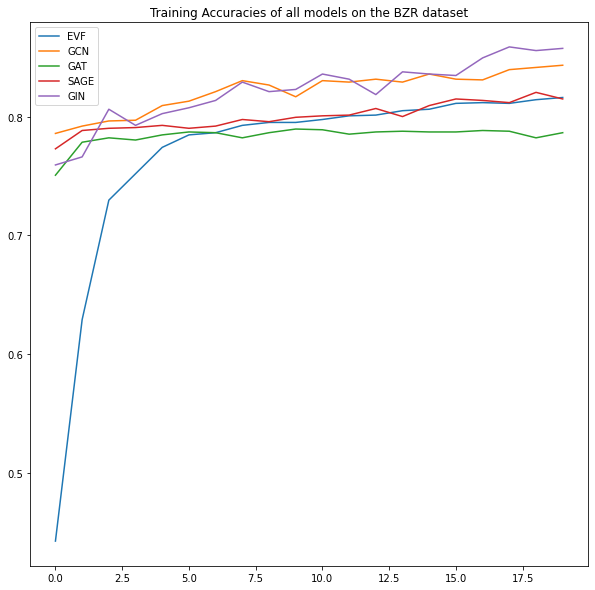

In [ ]:
# plot the training accuracies of all models on the COX2 dataset
plt.figure(figsize=(10,10))

plt.plot(EVF_train_accuracies, label='EVF')
plt.plot(GCN_train_accuracies, label='GCN')
plt.plot(GAT_train_accuracies, label='GAT')
plt.plot(SAGE_train_accuracies, label='SAGE')
plt.plot(GIN_train_accuracies, label='GIN')

plt.legend()

plt.title("Training Accuracies of all models on the BZR dataset")

plt.show()


In [ ]:
# plot the average accuracies and standard deviations on the BZR dataset in a table
print("Average Test Accuracies: ")
print("EVF: ", sum(EVF_accuracies)/len(EVF_accuracies), "Standard Deviation: ", np.std(EVF_accuracies))
print("GCN: ", sum(GCN_accuracies)/len(GCN_accuracies), "Standard Deviation: ", np.std(GCN_accuracies))
print("GAT: ", sum(GAT_accuracies)/len(GAT_accuracies), "Standard Deviation: ", np.std(GAT_accuracies))
print("SAGE: ", sum(SAGE_accuracies)/len(SAGE_accuracies), "Standard Deviation: ", np.std(SAGE_accuracies))
print("GIN: ", sum(GIN_accuracies)/len(GIN_accuracies), "Standard Deviation: ", np.std(GIN_accuracies))

Average Test Accuracies: 
EVF:  0.6790123456790123 Standard Deviation:  0.10591412636803564
GCN:  0.817283950617284 Standard Deviation:  0.03612034281068592
GAT:  0.7975308641975308 Standard Deviation:  0.022897823445668385
SAGE:  0.7901234567901234 Standard Deviation:  0.044854079319962846
GIN:  0.8222222222222222 Standard Deviation:  0.03083949628838716


# NCI1 dataset

## NOT IN THE REPORT DUE TO TIME CONSTRAINTS

In [ ]:
# NCI1 dataset
dataset = TUDataset(root='/tmp/NCI1', name='NCI1', use_node_attr=False)

In [ ]:


# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g).to_undirected()
    Z  = torch.linalg.eig(torch.tensor(nx.laplacian_matrix(G).todense()).float())[1][:,1:4]
    H = torch.tensor(g['x'])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

# plot the molecule
fig = plot_molecule(tdata[0])

fig.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/2552032803.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [211]:
class DeepEVfModel(torch.nn.Module):
    def __init__(
        self,
        dimH,
        num_classes = 2,
        num_vf = 5,
        evf_hidden_dim= 32,
        classifier_hidden_dim=16
    ):
    
        super().__init__()

        self.evf = nn.Sequential(nn.Linear(2*dimH, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, (1+2*dimH)*num_vf)
                      )

        self.classifier = nn.Sequential(nn.Linear(num_vf, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, classifier_hidden_dim),
                      nn.LeakyReLU(),
                      nn.Linear(classifier_hidden_dim, num_classes)
                      )
        
    def forward(self, tnsrdata):

        # calculate the invariant summary integratrix
        X = equi_integratrix(self.evf, tnsrdata['Z_chains'], tnsrdata['B'])

        # L2 readout layer
        X = torch.diag(X.T @ X)

        # apply the classifier to the output of the vector field
        pred = self.classifier(X)

        # apply softmax to the output of the classifier
        pred = nn.functional.log_softmax(pred, -1)

        return pred


Number of Parameters:  56 k
Epoch:  0 Loss:  0.5479702041169443
Training Accuracy:  0.5471411192214112 

Epoch:  1 Loss:  0.5373770380515601
Training Accuracy:  0.5766423357664233 

Epoch:  2 Loss:  0.5325695148577411
Training Accuracy:  0.5906326034063261 

Epoch:  3 Loss:  0.5294906635367631
Training Accuracy:  0.5863746958637469 

Epoch:  4 Loss:  0.5242433108552246
Training Accuracy:  0.5927615571776156 

Epoch:  5 Loss:  0.5210610586269904
Training Accuracy:  0.5988442822384428 

Epoch:  6 Loss:  0.5165753042103594
Training Accuracy:  0.6119221411192214 

Epoch:  7 Loss:  0.5159990500423979
Training Accuracy:  0.6067518248175182 

Epoch:  8 Loss:  0.5129602427770195
Training Accuracy:  0.6213503649635036 

Epoch:  9 Loss:  0.5087944447401959
Training Accuracy:  0.6183090024330901 

Epoch:  10 Loss:  0.5078636275249554
Training Accuracy:  0.6326034063260341 

Epoch:  11 Loss:  0.5050625544589553
Training Accuracy:  0.6347323600973236 

Epoch:  12 Loss:  0.5043128750973223
Training 

KeyboardInterrupt: 

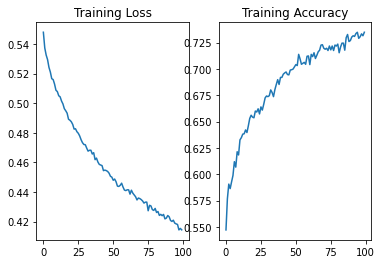

In [214]:
EVF_accuracies = []
EVF_losses = []
EVF_train_accuracies = []

for i in range(5):
    # construct evf mode
    model = DeepEVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 8, evf_hidden_dim= 64, classifier_hidden_dim=16)

    # initialise cross-entropy loss and adam optimizer
    criterion = nn.CrossEntropyLoss()

    # build an optimizer on evf and classifer parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # plot number of parameters in model
    print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

    # train the model
    model, all_loses, all_accuracies, test_accuracy = train_model(model, criterion, optimizer, tdata, epochs=100, batch_size=5)

    EVF_accuracies.append(test_accuracy)
    EVF_losses.append(all_loses)
    EVF_train_accuracies.append(all_accuracies)

print("Average Test Accuracy: ", sum(EVF_accuracies)/len(EVF_accuracies))
print("Standard Deviation: ", np.std(EVF_accuracies))


# take the mean of the losses
EVF_losses = torch.mean(torch.tensor(EVF_losses), axis=0)

# take the mean of the training accuracies
EVF_train_accuracies = torch.mean(torch.tensor(EVF_train_accuracies), axis=0)
